# Car Price prediction
(работа команды: "4 in 1 DS team@")

## Прогнозирование стоимости автомобиля по характеристикам

Описание:
Продолжение соревнования на Прогнозирование стоимости автомобиля но уже с дополнительными данными.

Вам поставлена задача создать модель, которая будет предсказывать стоимость автомобиля.
Если наша модель работает хорошо, то мы сможем быстро выявлять выгодные предложения (когда желаемая цена продавца ниже предсказанной рыночной цены). Это значительно ускорит работу менеджеров и повысит прибыль компании.


## В данному ноутбуке мы сделаем следующее:
* Построим "наивную"/baseline модель, предсказывающую цену по модели и году выпуска (с ней будем сравнивать другие модели)
* Обработаем и отнормируем признаки
* Сделаем первую модель на основе градиентного бустинга с помощью CatBoost
* Сделаем вторую модель на основе нейронных сетей и сравним результаты
* Сделаем multi-input нейронную сеть для анализа табличных данных и текста одновременно
* Добавим в multi-input сеть обработку изображений
* Осуществим ансамблирование градиентного бустинга и нейронной сети (усреднение их предсказаний)

In [1]:
from google.colab import drive
drive.mount('/content/drive') 


Mounted at /content/drive


In [2]:
!pip install -q tensorflow==2.3
!pip install catboost
!pip install pymorphy2
!pip install -U pymorphy2-dicts-ru

     |████████████████████████████████| 66.3MB 101kB/s 
     |████████████████████████████████| 61kB 3.1MB/s 
     |████████████████████████████████| 8.2MB 6.9MB/s 
Requirement already up-to-date: pymorphy2-dicts-ru in /usr/local/lib/python3.6/dist-packages (2.4.417127.4579844)


In [3]:
import random
import numpy as np
import pandas as pd
import os
import sys
import PIL
import cv2
import re
import pymorphy2

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# # keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import albumentations

# plt
import matplotlib.pyplot as plt
# увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
# графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg'
%matplotlib inline
#print(os.listdir("/content/drive/My Drive/cars2/"))
DATA_PATH = "/content/drive/My Drive/cars2/"
PATH = "/content/"  # рабочая директория

In [4]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.6.9 (default, Oct  8 2020, 12:12:24) 
Numpy        : 1.18.5
Tensorflow   : 2.3.0


In [5]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [6]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [7]:
!pip freeze > requirements.txt

# DATA

Загружаем данные

In [8]:
train = pd.read_csv(DATA_PATH + 'train.csv')
test = pd.read_csv(DATA_PATH + 'test.csv')
sample_submission = pd.read_csv(DATA_PATH + 'sample_submission.csv')

Посмотрим на типы признаков:

* bodyType - категориальный
* brand - категориальный
* color - категориальный
* description - текстовый
* engineDisplacement - числовой, представленный как текст
* enginePower - числовой, представленный как текст
* fuelType - категориальный
* mileage - числовой
* modelDate - числовой
* model_info - категориальный
* name - категориальный, желательно сократить размерность
* numberOfDoors - категориальный
* price - числовой, целевой
* productionDate - числовой
* sell_id - изображение (файл доступен по адресу, основанному на sell_id)
* vehicleConfiguration - не используется (комбинация других столбцов)
* vehicleTransmission - категориальный
* Владельцы - категориальный
* Владение - числовой, представленный как текст
* ПТС - категориальный
* Привод - категориальный
* Руль - категориальный

In [9]:
train.head()

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,price,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль
0,седан,BMW,чёрный,Авто на бодром ходу. Все работает отлично. П...,3.0 LTR,272 N12,бензин,245000,2007,5ER,530xi 3.0 AT (272 л.с.) 4WD,4,599000.0,2007,1099980990,SEDAN AUTOMATIC 3.0,автоматическая,3 или более,NaN,Оригинал,полный,Левый
1,седан,AUDI,серебристый,"Продажа от собственника, второй владелец, ПТС ...",2.8 LTR,204 N12,бензин,183000,2011,A6,2.8 CVT (204 л.с.),4,850000.0,2011,1095836906,SEDAN VARIATOR 2.8,вариатор,2 владельца,8 лет и 6 месяцев,Оригинал,передний,Левый
2,седан,MERCEDES,чёрный,Внимание! Только для клиентов AVILON Автомобил...,3.5 LTR,306 N12,бензин,122733,2009,E_KLASSE,350 3.5 AT (306 л.с.) 4WD,4,1325000.0,2013,1100195530,SEDAN AUTOMATIC 3.5,автоматическая,3 или более,NaN,Оригинал,полный,Левый
3,седан,AUDI,белый,В комплекте зимние колёса. 27.07.2020 Замена п...,2.0 LTR,180 N12,бензин,151000,2011,A6,2.0 CVT (180 л.с.),4,815000.0,2011,1099880662,SEDAN VARIATOR 2.0,вариатор,3 или более,4 года и 9 месяцев,Оригинал,передний,Левый
4,лифтбек,AUDI,белый,"Отличный авто, 2011 года выпуска, кроме передн...",1.8 LTR,160 N12,бензин,140000,2007,A5,1.8 CVT (160 л.с.),5,810000.0,2011,1083244610,LIFTBACK VARIATOR 1.8,вариатор,3 или более,2 года и 9 месяцев,Оригинал,передний,Левый


# Model 1: Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели и году выпуска. 
C ней будем сравнивать другие модели.



In [10]:
# split данных
data_train, data_test = train_test_split(
    train, test_size=0.0848, shuffle=True, random_state=RANDOM_SEED)

In [11]:
# Наивная модель
predicts = []
for index, row in pd.DataFrame(data_test[['model_info', 'productionDate']]).iterrows():
    query = f"model_info == '{row[0]}' and productionDate == '{row[1]}'"
    predicts.append(data_train.query(query)['price'].median())

# заполним не найденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# округлим
predicts = (predicts // 1000) * 1000

# оцениваем точность
print(
    f"Точность наивной модели по метрике MAPE: {(mape(data_test['price'], predicts.values[:, 0]))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 18.61%


In [12]:
predicts.head()

,0
0,680000.0
1,910000.0
2,1299000.0
3,570000.0
4,1270000.0


# EDA

Проведем быстрый анализ данных для того, чтобы понимать, сможет ли с этими данными работать наш алгоритм.

# PreProc Tabular Data

In [13]:
# ВАЖНО! для корректной обработки признаков объединяем трейн и тест в один датасет
train['sample'] = 1  # помечаем где у нас трейн
test['sample'] = 0  # помечаем где у нас тест
# в тесте у нас нет значения price, мы его должны предсказать, поэтому пока просто заполняем нулями
test['price'] = 0

data = test.append(train, sort=False).reset_index(drop=True)  # объединяем
print(train.shape, test.shape, data.shape)

(6682, 23) (1671, 23) (8353, 23)


In [14]:
# смотрим сколько каких уникальных признаков у нас есть:
data.nunique()

bodyType                  17
brand                      3
color                     16
description             7654
engineDisplacement        48
enginePower              154
fuelType                   4
mileage                 3507
modelDate                 43
model_info               122
name                     976
numberOfDoors              4
productionDate            39
sell_id                 8353
vehicleConfiguration     312
vehicleTransmission        4
Владельцы                  3
Владение                 180
ПТС                        2
Привод                     3
Руль                       2
sample                     2
price                   1629
dtype: int64

In [15]:
# удалим дубликаты (если они есть):
data.drop_duplicates()

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,sample,price
0,универсал 5 дв.,MERCEDES,чёрный,Всем привет!\n\nПродам эксклюзивный проект 124...,3.0 LTR,220 N12,бензин,350000,1984,W124,300 3.0 AT (220 л.с.),5,1991,1099427284,WAGON_5_DOORS AUTOMATIC 3.0,автоматическая,3 или более,6 лет и 3 месяца,Оригинал,задний,Левый,0,0.0
1,купе,BMW,белый,Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...,3.0 LTR,313 N12,дизель,15000,2011,6ER,640d xDrive 3.0d AT (313 л.с.) 4WD,2,2013,1096405886,COUPE AUTOMATIC 3.0,автоматическая,1 владелец,6 лет и 6 месяцев,Оригинал,полный,Левый,0,0.0
2,купе,BMW,пурпурный,"Машина тут продаётся не в первый раз, НО! Толь...",2.5 LTR,218 N12,бензин,166600,2005,3ER,325xi 2.5 AT (218 л.с.) 4WD,2,2008,1100195294,COUPE AUTOMATIC 2.5,автоматическая,3 или более,NaN,Оригинал,полный,Левый,0,0.0
3,седан,BMW,белый,"Автомобиль в отличном состоянии, весь в родной...",2.0 LTR,136 N12,бензин,147000,2005,3ER,318i 2.0 AT (136 л.с.),4,2007,1099827282,SEDAN AUTOMATIC 2.0,автоматическая,2 владельца,NaN,Оригинал,задний,Левый,0,0.0
4,седан,BMW,чёрный,Немка! с бесключивым доступом и камерой заднег...,2.0 LTR,190 N12,дизель,24000,2016,5ER,520d xDrive 2.0d AT (190 л.с.) 4WD,4,2019,1100076198,SEDAN AUTOMATIC 2.0,автоматическая,1 владелец,NaN,Оригинал,полный,Левый,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8348,седан,BMW,серый,Продаётся любимый автомобиль! За годы эксплуат...,2.0 LTR,150 N12,бензин,232777,2005,3ER,320i 2.0 AT (150 л.с.),4,2006,1100036650,SEDAN AUTOMATIC 2.0,автоматическая,3 или более,NaN,Оригинал,задний,Левый,1,550000.0
8349,седан,BMW,чёрный,Куплена у официального дилера в 2017 г. \n\nТр...,2.0 LTR,190 N12,дизель,33700,2013,5ER,520d 2.0d AT (190 л.с.),4,2016,1090506038,SEDAN AUTOMATIC 2.0,автоматическая,3 или более,2 года и 2 месяца,Оригинал,задний,Левый,1,1900000.0
8350,седан,BMW,белый,Торг на месте. Все работает. Сборка немецкая. ...,2.0 LTR,143 N12,бензин,200000,2008,3ER,318i 2.0 AT (143 л.с.),4,2008,1095155628,SEDAN AUTOMATIC 2.0,автоматическая,3 или более,2 года и 2 месяца,Оригинал,задний,Левый,1,530000.0
8351,седан,AUDI,чёрный,Автомобиль в отличном состоянии.\n3-из Авто в ...,3.0 LTR,310 N12,бензин,72000,2013,A8,Long 3.0 AT (310 л.с.) 4WD,4,2016,1099625256,SEDAN AUTOMATIC 3.0,автоматическая,3 или более,NaN,Оригинал,полный,Левый,1,1970000.0


In [16]:
# смотрим на наличие пропусков:"Владение" (больше 60%) и "Владельцы" (1 пропуск)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              8353 non-null   object 
 1   brand                 8353 non-null   object 
 2   color                 8353 non-null   object 
 3   description           8353 non-null   object 
 4   engineDisplacement    8353 non-null   object 
 5   enginePower           8353 non-null   object 
 6   fuelType              8353 non-null   object 
 7   mileage               8353 non-null   int64  
 8   modelDate             8353 non-null   int64  
 9   model_info            8353 non-null   object 
 10  name                  8353 non-null   object 
 11  numberOfDoors         8353 non-null   int64  
 12  productionDate        8353 non-null   int64  
 13  sell_id               8353 non-null   int64  
 14  vehicleConfiguration  8353 non-null   object 
 15  vehicleTransmission  

In [17]:
# engineDisplacement преобразуем в числовой признак:
def engineDisplacement(row):
    row = str(row)
    engine = re.findall('\d\.\d', row)
    if engine == []:
        return None
    return float(engine[0])


data['engineDisplacement'] = data['engineDisplacement'].apply(
    engineDisplacement)
data['engineDisplacement'].fillna(
    data['engineDisplacement'].median(), inplace=True)
data.engineDisplacement = data.engineDisplacement .apply(lambda x: float(x))
# data['engineDisplacement']= np.log(data['engineDisplacement']) # - хуже результат

In [18]:
data['engineDisplacement'].unique()

array([3. , 2.5, 2. , 3.5, 1.8, 2.2, 5.5, 4.8, 1.6, 4.7, 4. , 1.5, 2.4,
       1.4, 2.1, 5.2, 4.4, 2.8, 4.2, 3.2, 6. , 3.7, 5. , 1.2, 3.6, 2.3,
       6.2, 1.7, 1.3, 5.4, 3.1, 2.6, 3.8, 4.1, 2.9, 6.6, 5.9, 2.7, 0.7,
       1.9, 4.3, 5.8, 4.9, 3.4, 6.3, 5.6, 4.6])

In [19]:
data.loc[data.engineDisplacement == 'undefined', 'engineDisplacement'] = '2.0'
data.loc[data.engineDisplacement == '0.7', 'engineDisplacement'] = '1.0'

In [20]:
# вариант 1: просто  удалим  признак  "Владение"
#data = data.drop('Владение', axis = 1)

# вариант 2:выделим пропуски  признака  "Владение" в отдельную категорию
#data.Владение.fillna('X', inplace=True)


# вариант 3: этот вариант дал самый лучший результат, поэтому используем его.
# Преобразуем срок владения в (месяцы) числовое значение и заполним пропуски
def num_of_months(row):
    if pd.notnull(row):
        list_ownership = row.split()
        if len(list_ownership) == 2:
            if list_ownership[1] in ['год', 'года', 'лет']:
                return int(list_ownership[0])*12
            return int(list_ownership[0])
        return int(list_ownership[0])*12 + int(list_ownership[3])


data['Владение'] = data['Владение'].apply(num_of_months)
# data['Владение'].fillna(data['Владение'].median(),inplace=True)
data['Владение'] = data['Владение'].astype(float)
# data['Владение']= np.log(data['Владение']) # логарифм для нейросети

In [21]:
# т.к. пропусков очень много, выделим отдельный признак на базе пропусков "Владение"
# Spoiler - это ухудшило результат!(лучше удалить)
data['ВладениеX'] = data['Владение']  # убрать этот признак
data['ВладениеX'].fillna(0, inplace=True)

In [22]:
data['ВладениеX'] = data['ВладениеX'].astype(int)
data['ВладениеX']

0       75
1       78
2        0
3        0
4        0
        ..
8348     0
8349    26
8350    26
8351     0
8352     0
Name: ВладениеX, Length: 8353, dtype: int64

In [23]:
data['ВладениеX'] = data['ВладениеX'].apply(lambda x: "A" if x == 0 else "B")
data['ВладениеX']

0       B
1       B
2       A
3       A
4       A
       ..
8348    A
8349    B
8350    B
8351    A
8352    A
Name: ВладениеX, Length: 8353, dtype: object

In [24]:
# Заполним пропуски "Владение" медианой
data['Владение'].fillna(data['Владение'].median(), inplace=True)
data['Владение'] = data['Владение'].astype(float)
data['Владение'].isnull().sum()

0

In [25]:
# наводим порядок с пропуском в "Владельцы" заполняем самым частым значением:
data['Владельцы'] = data[['Владельцы']].fillna(
    data['Владельцы'].value_counts().index[0])
# Владельцы, оставим только цифру
data['Владельцы'] = data['Владельцы'].apply(lambda x: str(x.split()[0]))
data['Владельцы'] = data['Владельцы'].astype(str)

In [26]:
# vehicleConfiguration, выведем только трансмиссию
data['vehicleConfiguration'] = data['vehicleConfiguration'].apply(
    lambda x: x.split()[1])

In [27]:
# enginePower, оставим только число в enginePower:
data['enginePower'] = data['enginePower'].apply(lambda x: float(x.split()[0]))

In [28]:
# введем новый признак "tax" (расчет годового налога):
data['tax'] = data.enginePower.apply(lambda x: x*12 if x <= 100
                                     else x*25 if x > 100 and x <= 125
                                     else x*35 if x > 125 and x <= 150
                                     else x*45 if x > 150 and x <= 175
                                     else x*55 if x > 175 and x <= 200
                                     else x*65 if x > 200 and x <= 225
                                     else x*75 if x > 225 and x <= 250
                                     else x*150)

In [29]:
#  введем новый признак "tax_cat" (разбивка налога на категории )деление на 8 категорий (как по НК РФ)
data['tax_cat'] = data.enginePower.apply(lambda x: 1 if x <= 100
                                         else 2 if x > 100 and x <= 125
                                         else 3 if x > 125 and x <= 150
                                         else 4 if x > 150 and x <= 175
                                         else 5 if x > 175 and x <= 200
                                         else 6 if x > 200 and x <= 225
                                         else 7 if x > 225 and x <= 250
                                         else 8)

In [30]:
data['tax_cat'] = data['tax_cat'].astype(str)
data['tax_cat']

0       6
1       8
2       6
3       3
4       5
       ..
8348    3
8349    5
8350    3
8351    8
8352    8
Name: tax_cat, Length: 8353, dtype: object

In [31]:
# преобразуем productionDate в чистый возраст авто:
data['productionDate'] = 2021 - data['productionDate']
data['productionDate'] = data['productionDate'] .astype(float)

In [32]:
# преобразуем modelDate в чистый возраст модели:
data['modelDate'] = 2021 - data['modelDate']
data['modelDate'] = data['modelDate'].astype(float)

In [33]:
# Пока мы не преобразовали признаки age и mileage, создадим ещё один признак - mileagePerYear, который покажет, насколько интенсивно использовали автомобиль.
# Поделим  признак  на 4 категорий.

In [34]:
data['mileage'] = data['mileage'].astype(float)

In [35]:
data['mileagePerYearN'] = (data['mileage'] / data['productionDate'])
data['mileagePerYearN'] = data['mileagePerYearN'].round()


def cat_mileagePerYear(x):
  # km per year category
    if x < 10000:
        x = 1
    elif 10000 <= x < 20000:
        x = 2
    elif 20000 <= x < 30000:
        x = 3
    elif 30000 <= x:
        x = 4
    return x


data['mileagePerYear'] = data['mileagePerYearN'].apply(
    lambda x: cat_mileagePerYear(x))
data['mileagePerYear'] = data['mileagePerYear'].astype(str)
data['mileagePerYear']

0       2
1       1
2       2
3       2
4       2
       ..
8348    2
8349    1
8350    2
8351    2
8352    1
Name: mileagePerYear, Length: 8353, dtype: object

In [36]:
data['mileagePerYearN']

0       11667.0
1        1875.0
2       12815.0
3       10500.0
4       12000.0
         ...   
8348    15518.0
8349     6740.0
8350    15385.0
8351    14400.0
8352      852.0
Name: mileagePerYearN, Length: 8353, dtype: float64

In [37]:
# чистим признак numberOfDoors и иставляем только числовую  составляющую, переводим в категориальный признак.
data['numberOfDoors'] = data['numberOfDoors'].apply(lambda s: str(int(s)))

In [38]:
# чистим признак name и иставляем только 1-ую составляющую названия, дабы уменьшить кол-во уникальных позиций признака.
data['name'] = data['name'].str.split().apply(lambda s: s[0])

In [39]:
data['name'].nunique()

236

In [40]:
# чистим признак bodyType и иставляем только 1-ую составляющую названия, дабы уменьшить кол-во уникальных позиций признака.
data.bodyType = data.bodyType.str.split().apply(lambda s: s[0])
data.bodyType.unique()

array(['универсал', 'купе', 'седан', 'внедорожник', 'родстер', 'лифтбек',
       'хэтчбек', 'купе-хардтоп', 'минивэн', 'кабриолет', 'пикап',
       'компактвэн', 'лимузин'], dtype=object)

In [41]:
data.head()

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,sample,price,ВладениеX,tax,tax_cat,mileagePerYearN,mileagePerYear
0,универсал,MERCEDES,чёрный,Всем привет!\n\nПродам эксклюзивный проект 124...,3,220.0,бензин,350000.0,37.0,W124,300,5,30.0,1099427284,AUTOMATIC,автоматическая,3,75.0,Оригинал,задний,Левый,0,0.0,B,14300.0,6,11667.0,2
1,купе,BMW,белый,Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...,3,313.0,дизель,15000.0,10.0,6ER,640d,2,8.0,1096405886,AUTOMATIC,автоматическая,1,78.0,Оригинал,полный,Левый,0,0.0,B,46950.0,8,1875.0,1
2,купе,BMW,пурпурный,"Машина тут продаётся не в первый раз, НО! Толь...",2.5,218.0,бензин,166600.0,16.0,3ER,325xi,2,13.0,1100195294,AUTOMATIC,автоматическая,3,38.0,Оригинал,полный,Левый,0,0.0,A,14170.0,6,12815.0,2
3,седан,BMW,белый,"Автомобиль в отличном состоянии, весь в родной...",2,136.0,бензин,147000.0,16.0,3ER,318i,4,14.0,1099827282,AUTOMATIC,автоматическая,2,38.0,Оригинал,задний,Левый,0,0.0,A,4760.0,3,10500.0,2
4,седан,BMW,чёрный,Немка! с бесключивым доступом и камерой заднег...,2,190.0,дизель,24000.0,5.0,5ER,520d,4,2.0,1100076198,AUTOMATIC,автоматическая,1,38.0,Оригинал,полный,Левый,0,0.0,A,10450.0,5,12000.0,2


In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              8353 non-null   object 
 1   brand                 8353 non-null   object 
 2   color                 8353 non-null   object 
 3   description           8353 non-null   object 
 4   engineDisplacement    8353 non-null   object 
 5   enginePower           8353 non-null   float64
 6   fuelType              8353 non-null   object 
 7   mileage               8353 non-null   float64
 8   modelDate             8353 non-null   float64
 9   model_info            8353 non-null   object 
 10  name                  8353 non-null   object 
 11  numberOfDoors         8353 non-null   object 
 12  productionDate        8353 non-null   float64
 13  sell_id               8353 non-null   int64  
 14  vehicleConfiguration  8353 non-null   object 
 15  vehicleTransmission  

Посмотрим, как выглядят распределения числовых признаков:

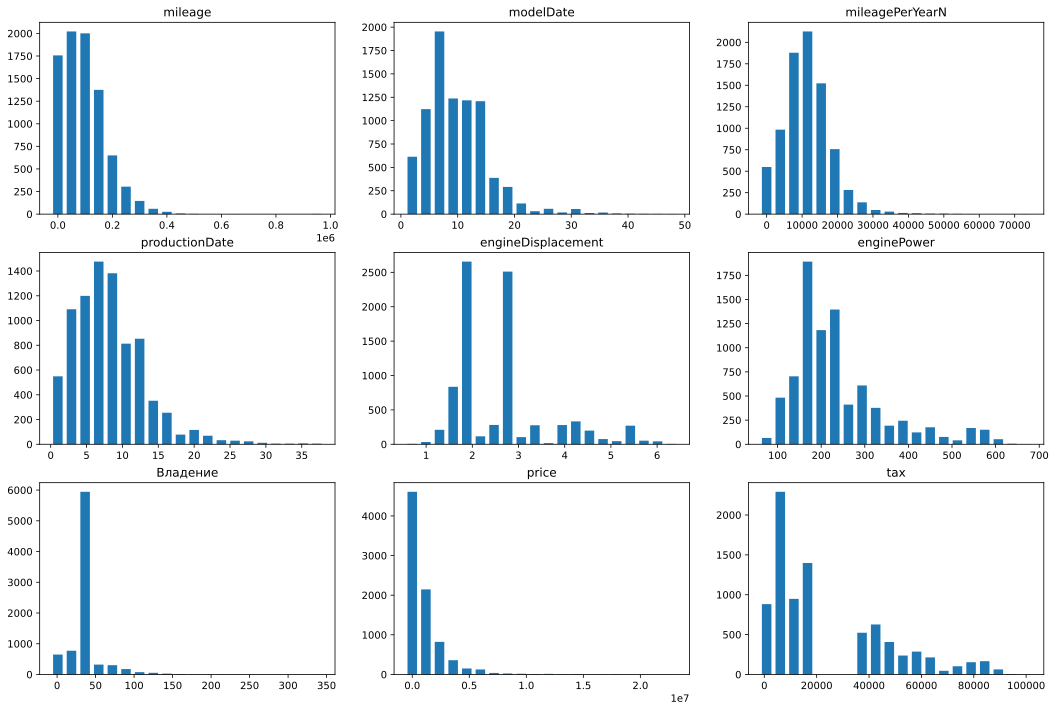

In [43]:
# посмотрим, как выглядят распределения числовых признаков
def visualize_distributions(titles_values_dict):
    columns = min(3, len(titles_values_dict))
    rows = (len(titles_values_dict) - 1) // columns + 1
    fig = plt.figure(figsize=(columns * 6, rows * 4))
    for i, (title, values) in enumerate(titles_values_dict.items()):
        hist, bins = np.histogram(values, bins=20)
        ax = fig.add_subplot(rows, columns, i + 1)
        ax.bar(bins[:-1], hist, width=(bins[1] - bins[0]) * 0.7)
        ax.set_title(title)
    plt.show()


visualize_distributions({
    'mileage': data['mileage'].dropna(),
    'modelDate': data['modelDate'].dropna(),
    'mileagePerYearN': data['mileagePerYearN'].dropna(),
    'productionDate': data['productionDate'].dropna(),
    'engineDisplacement': data['engineDisplacement'].dropna(),
    'enginePower': data['enginePower'].dropna(),
    'Владение': data['Владение'].dropna(),
    'enginePower': data['enginePower'].dropna(),
    'price': data['price'].dropna(),
    'tax': data['tax'].dropna()

})

Итого: распределение не везде нормальное,  можно отдельные признаки логарифмировать (но как показала практика, в данном случае это себя не оправдало), поэтому мы не будем логарифмировать.
* CatBoost сможет работать с признаками и в таком виде, но для нейросети нужны нормированные данные.

In [44]:
#data['Владение']= np.log(data['Владение']) # для нейросети
#data['mileage']= np.log(data['mileage']) # для нейросети
#data['modelDate']= np.log(data['modelDate']) # для нейросети
#data['productionDate']= np.log(data['productionDate']) # для нейросети

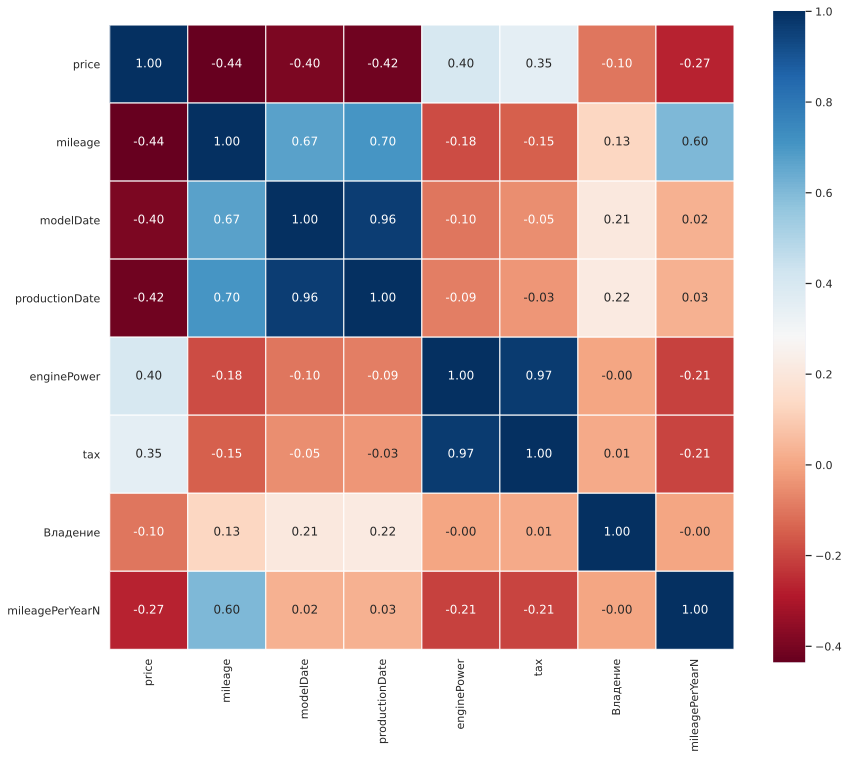

In [45]:
# Проверяем на мультиколлинеарность и кореляцию числовых признаков между собой и с главным признаком "price":
import seaborn as sns
import matplotlib.pyplot as plt
data_number = data[["price", 'mileage', 'modelDate', 'productionDate', 'engineDisplacement',
                    'enginePower', 'tax', 'Владение', "mileagePerYearN"]]

sns.set(font_scale=1)
plt.subplots(figsize=(14, 12))
sns.heatmap(data_number.corr(), square=True, annot=True,
            fmt=".2f", linewidths=1, cmap="RdBu")

# Анализ числовых признаков:
Карта корреляции  показывает, что  сильной зависимости  с "price" нет ни у одного признака. 
Тем не менее 'mileage', 'modelDate', 'productionDate', 'engineDisplacement','enginePower','tax', 'Владение', "mileagePerYearN" оказывают влияние на таргет.

# Анализ категориальных признаков:
Очевидно, что для номинативных переменных использовать корреляционный анализ не получится.
Однако можно посмотреть, различаются ли распределения "price" в зависимости от значения этих переменных. Это можно сделать, например,
 с помощью box-plot или KDE-plot (график показывает плотность распределения переменных).

In [46]:
data_categorical = ['bodyType', 'brand', 'color',  'fuelType', 'model_info', 'name', 'ВладениеX',
                    'vehicleTransmission', 'ПТС', 'Привод', 'Руль', 'mileagePerYear', 'numberOfDoors', 'tax_cat', 'Владельцы', 'vehicleConfiguration'
                    ]

In [47]:
def get_boxplot(column):
    fig, ax = plt.subplots(figsize=(15, 10))
    sns.boxplot(x=column, y='price',
                data=data.loc[data.loc[:, column].isin(data.loc[:, column].value_counts().index[:10])], ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

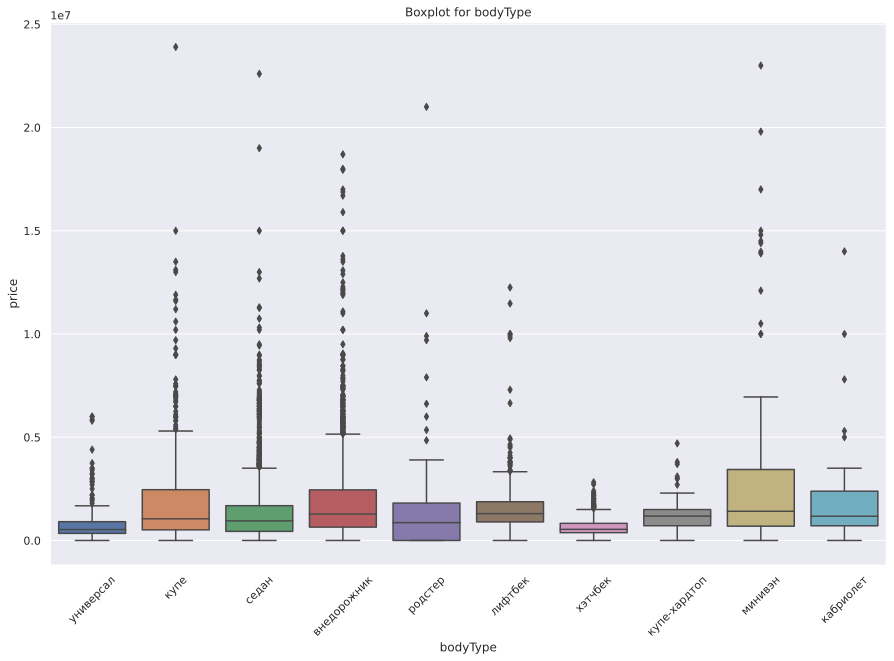

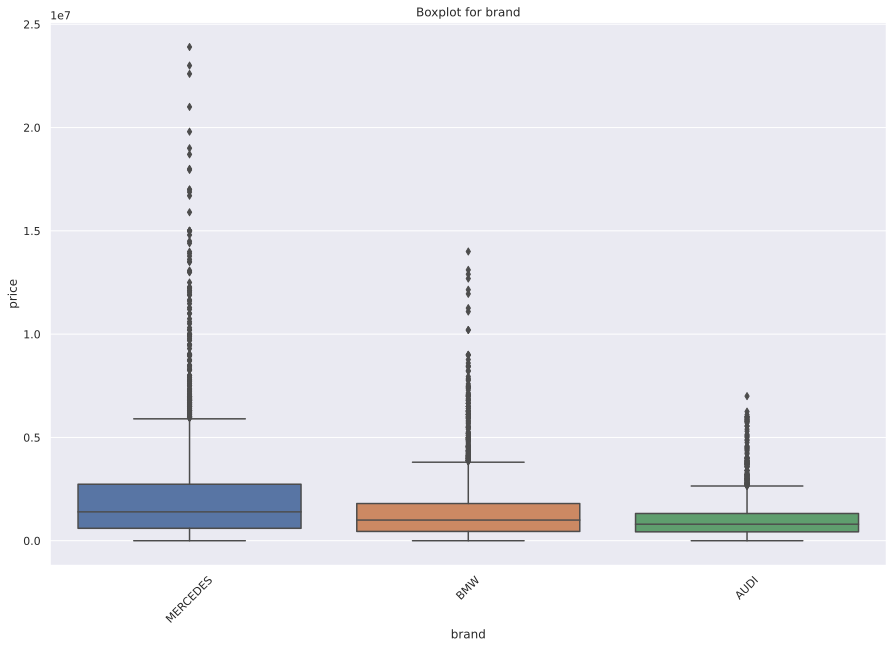

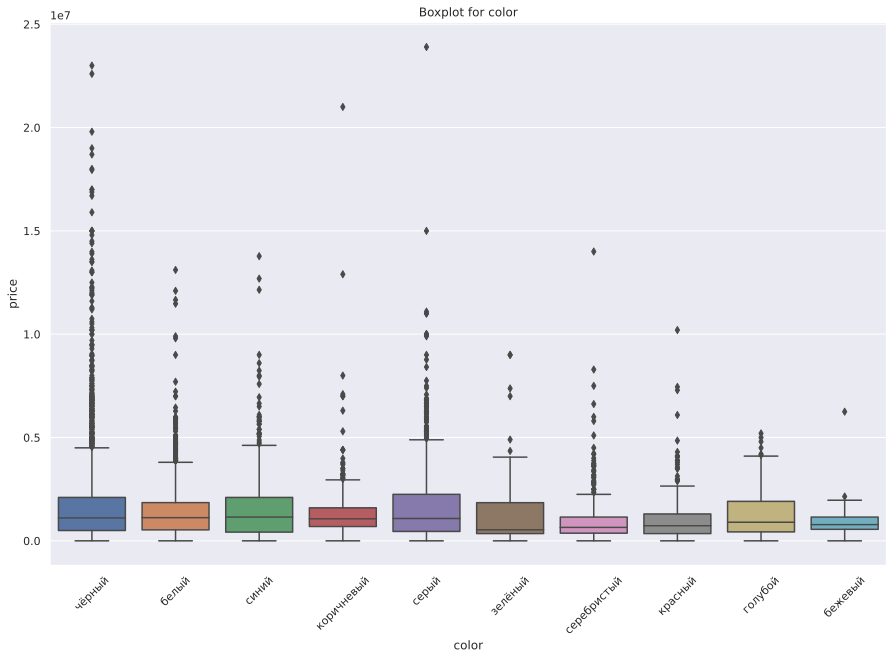

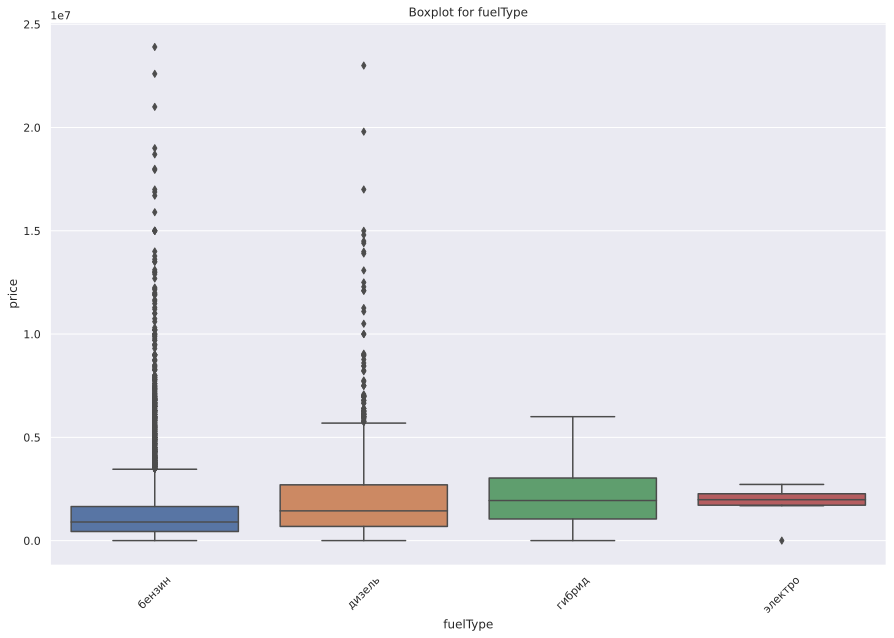

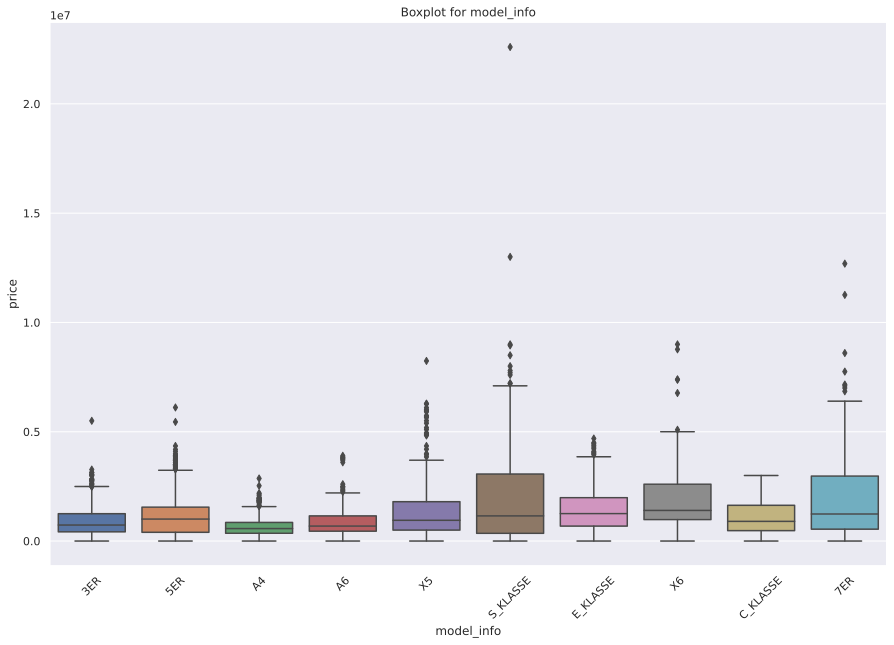

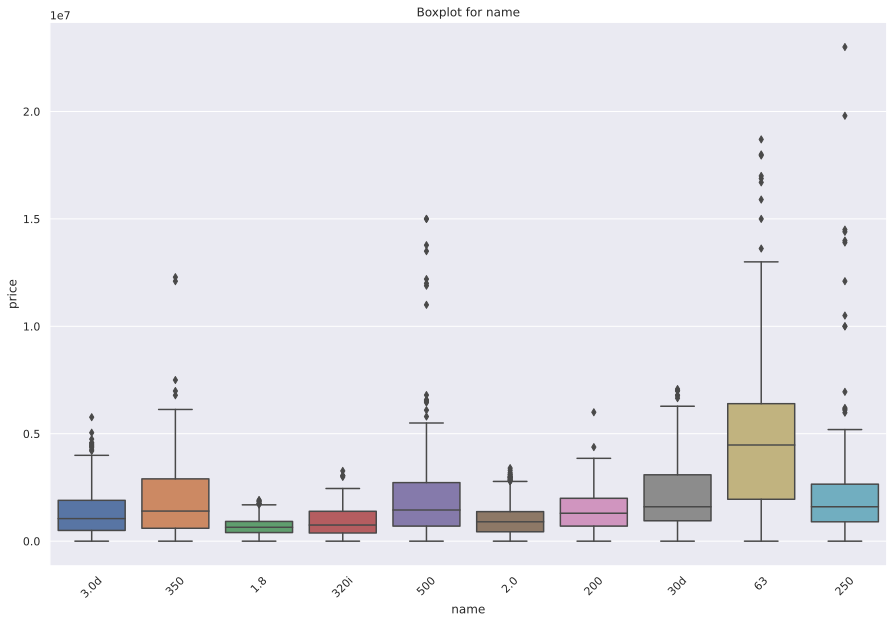

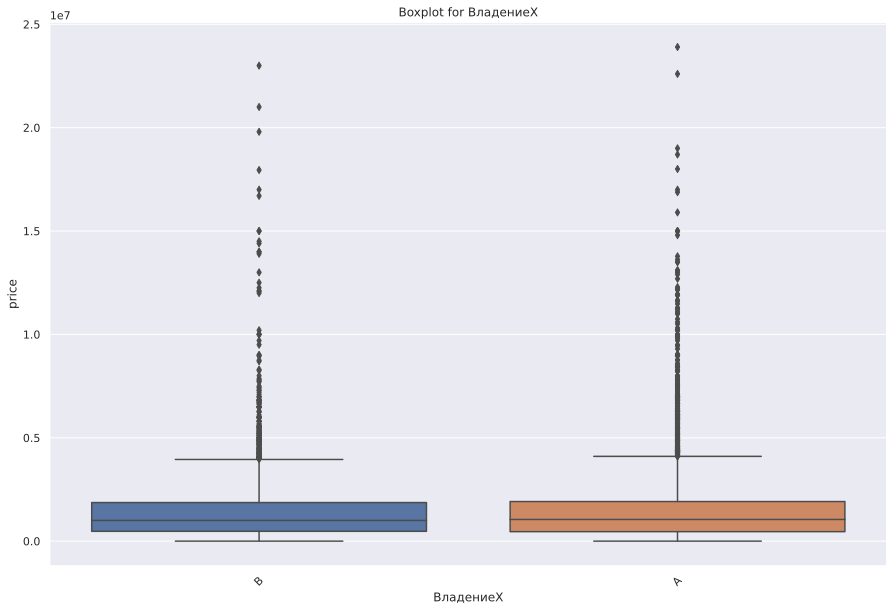

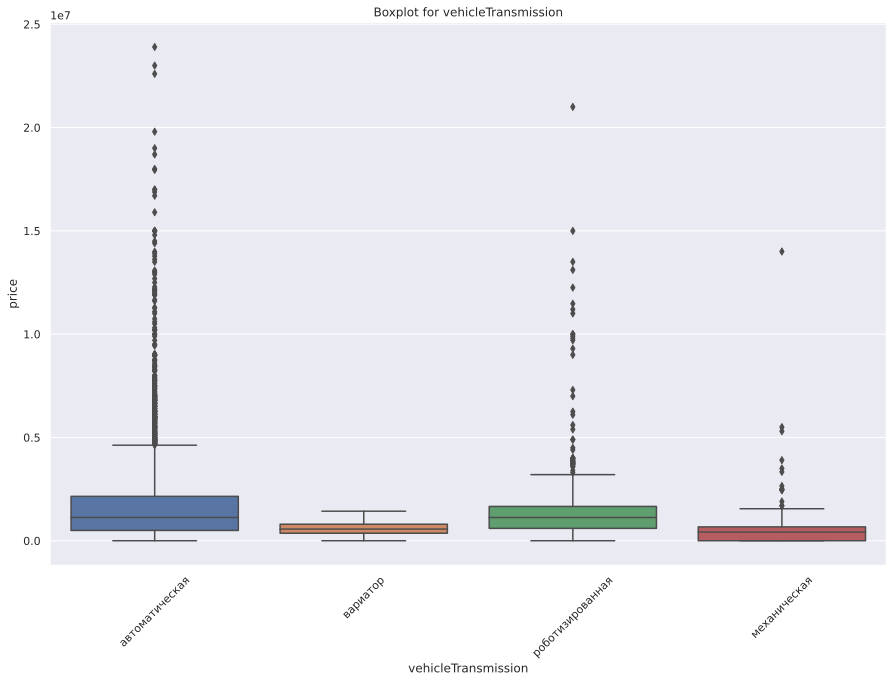

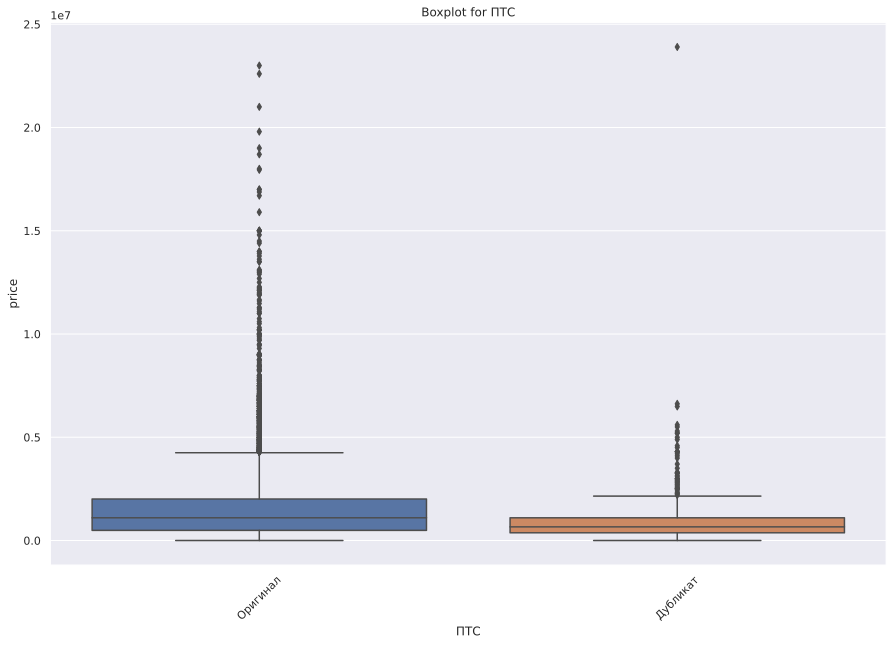

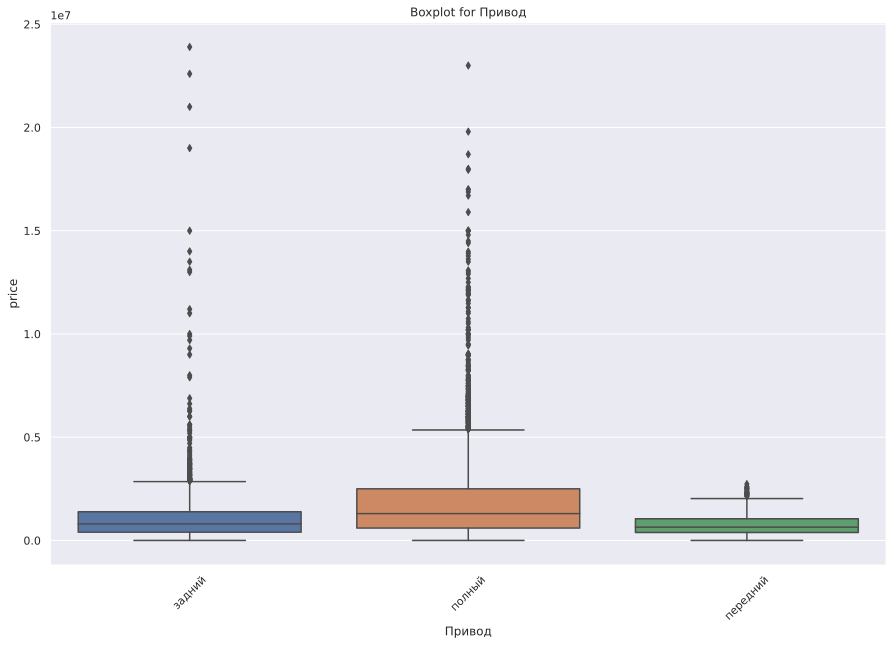

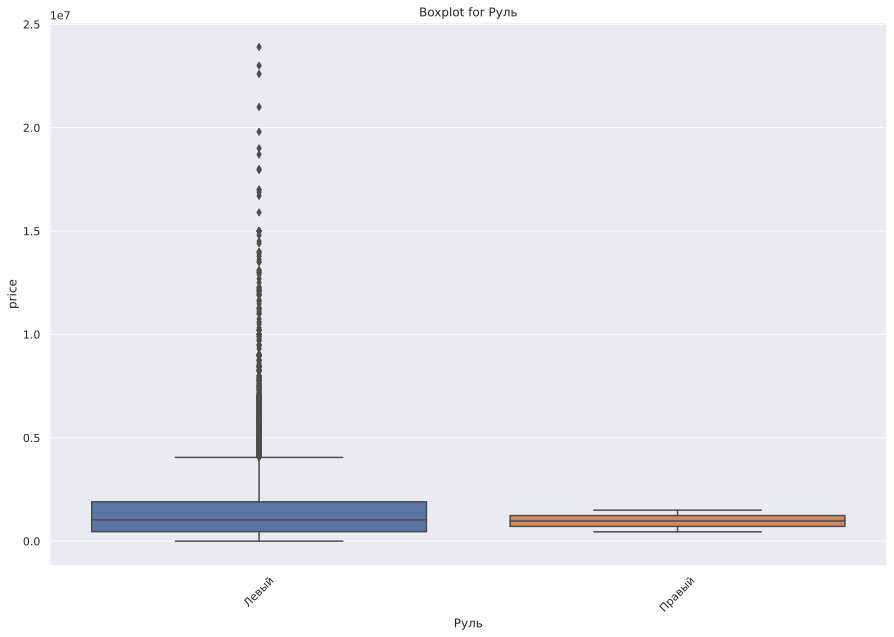

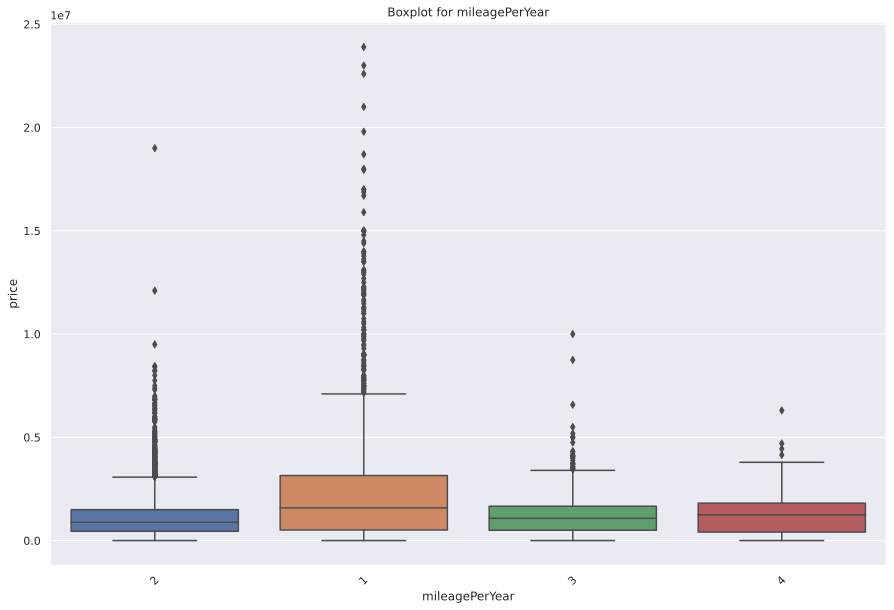

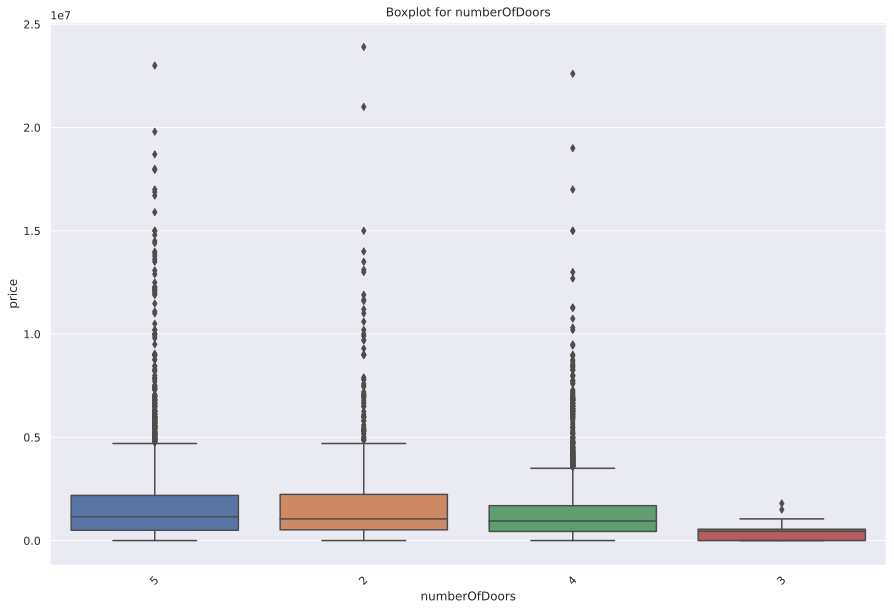

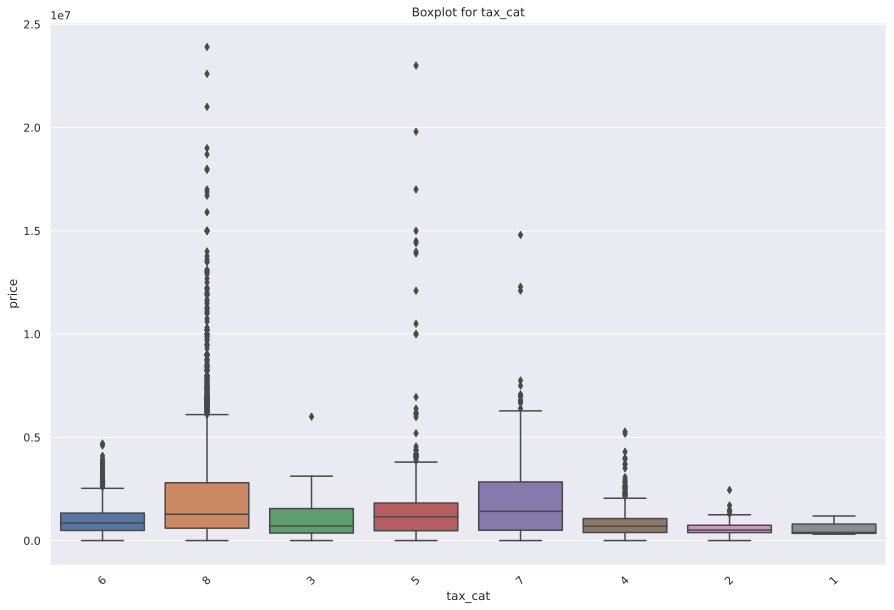

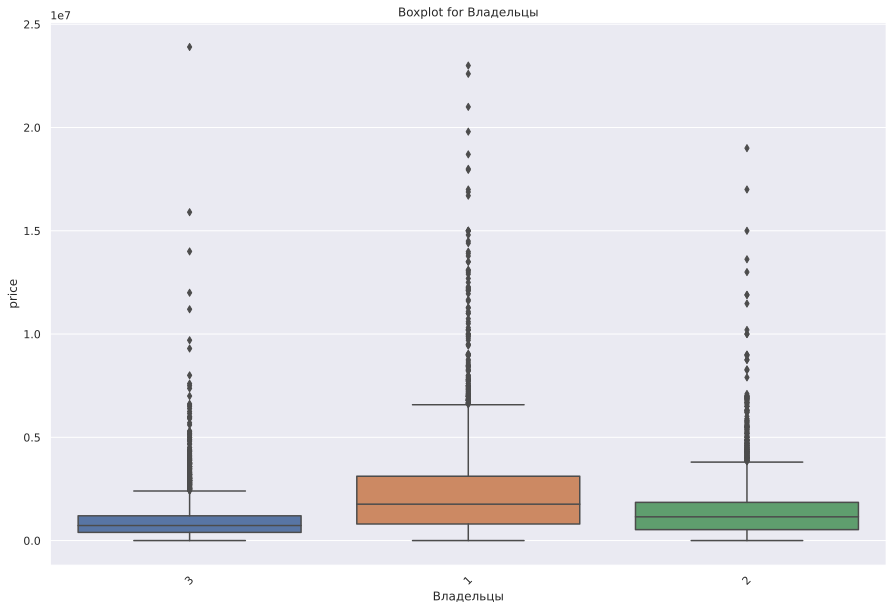

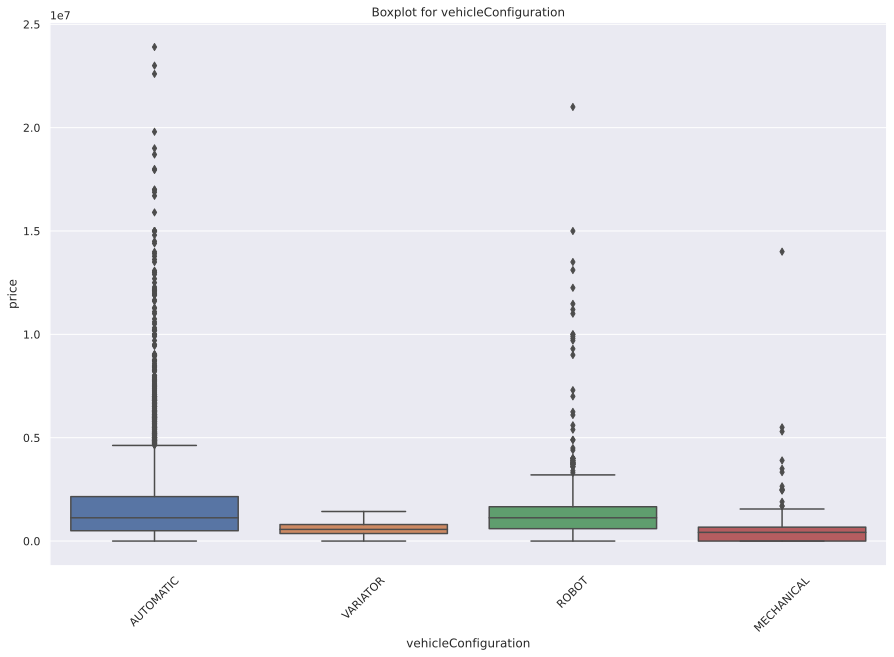

In [48]:
# Посмотрим финально на категориальные признаки:
for column in data_categorical:
    get_boxplot(column)

Было много размышлений как сформировать распределение признаков на категориальные и числовые, в финале остановились  на таком распределении как самом результативном (хотя некоторые признаки можно  было отнести как к одной так и другой категории):

In [49]:
# Составим итоговый список категориальных признаков для модели:
categorical_features = ['bodyType', 'brand', 'color',  'fuelType', 'model_info', 'name',  # 'ВладениеX'
                        'vehicleTransmission', 'ПТС', 'Привод', 'Руль', 'mileagePerYear', 'numberOfDoors', 'tax_cat', 'Владельцы']
 
# Составим список числовых признаков:
numerical_features = ['mileage', 'modelDate', 'productionDate', 'engineDisplacement','enginePower','tax', 'mileagePerYear',"Владельцы",
                      'Владение'#, "mileagePerYearN"
                      ]

In [50]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''

    df_output = df_input.copy()

    # ################### 1. Предобработка ##############################################################
    # убираем не нужные для модели признаки (сделали  это выше)

    df_output.drop(['description', 'sell_id',
                    'vehicleConfiguration', "mileagePerYearN",
                    'ВладениеX'], axis=1, inplace=True)
    # ################### Numerical Features ##############################################################
    # Далее заполняем пропуски
    for column in numerical_features:
        df_output[column].fillna(df_output[column].median(), inplace=True)
    # тут ваш код по обработке NAN (сделали это выше)

    # Нормализация данных и логорифмирование
    # CatBoost сможет работать с признаками и в таком виде, но для нейросети нужны нормированные данные.
    scaler = MinMaxScaler()
    for column in numerical_features:
       # df_output[column] = np.log(df_output[column]) # это ухудшило результат
        df_output[column] = scaler.fit_transform(df_output[[column]])[:, 0]

    # ################### Categorical Features ##############################################################
    # Label Encoding
    for column in categorical_features:
        df_output[column] = df_output[column].astype('category').cat.codes

    # One-Hot Encoding: в pandas есть готовая функция - get_dummies.
    df_output = pd.get_dummies(
        df_output, columns=categorical_features, dummy_na=False)
    # тут ваш код не Encoding фитчей (сделали это выше)

    # ################### Feature Engineering ####################################################
    # тут ваш код не генерацию новых фитчей (сделали это выше)

    # ################### Clean ####################################################
    # убираем признаки которые еще не успели обработать,
    #df_output.drop(['vehicleConfiguration'], axis = 1, inplace=True)

    return df_output

In [51]:
# Запускаем и проверяем, что получилось
df_preproc = preproc_data(data)
df_preproc.sample(10)

,engineDisplacement,enginePower,mileage,modelDate,productionDate,Владение,sample,price,tax,bodyType_0,bodyType_1,bodyType_2,bodyType_3,bodyType_4,bodyType_5,bodyType_6,bodyType_7,bodyType_8,bodyType_9,bodyType_10,bodyType_11,bodyType_12,brand_0,brand_1,brand_2,color_0,color_1,color_2,color_3,color_4,color_5,color_6,color_7,color_8,color_9,color_10,color_11,color_12,color_13,color_14,...,name_226,name_227,name_228,name_229,name_230,name_231,name_232,name_233,name_234,name_235,vehicleTransmission_0,vehicleTransmission_1,vehicleTransmission_2,vehicleTransmission_3,ПТС_0,ПТС_1,Привод_0,Привод_1,Привод_2,Руль_0,Руль_1,mileagePerYear_0,mileagePerYear_1,mileagePerYear_2,mileagePerYear_3,numberOfDoors_0,numberOfDoors_1,numberOfDoors_2,numberOfDoors_3,tax_cat_0,tax_cat_1,tax_cat_2,tax_cat_3,tax_cat_4,tax_cat_5,tax_cat_6,tax_cat_7,Владельцы_0,Владельцы_1,Владельцы_2
7399,0.220339,0.2720,0.106999,0.104167,0.131579,0.158192,1,1590000.0,0.167867,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0
4273,0.220339,0.2720,0.044999,0.125000,0.105263,0.081921,1,3100000.0,0.167867,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0
3362,0.813559,0.8160,0.054999,0.125000,0.131579,0.104520,1,3750000.0,0.834294,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1
2794,0.389831,0.2720,0.124999,0.166667,0.236842,0.104520,1,1990000.0,0.167867,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1
5378,0.220339,0.2288,0.148999,0.125000,0.131579,0.104520,1,1285000.0,0.127474,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
5902,0.559322,0.7760,0.069799,0.145833,0.184211,0.104520,1,3399999.0,0.798271,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0
1454,0.389831,0.3920,0.052765,0.145833,0.131579,0.104520,0,0.0,0.452450,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0
2476,0.305085,0.2288,0.173499,0.250000,0.315789,0.115819,1,700000.0,0.127474,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
743,0.152542,0.0640,0.119999,0.250000,0.263158,0.104520,0,0.0,0.018972,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1
1168,0.813559,0.7504,0.035999,0.145833,0.157895,0.104520,0,0.0,0.775216,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1


In [52]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Columns: 433 entries, engineDisplacement to Владельцы_2
dtypes: float64(8), int64(1), uint8(424)
memory usage: 4.0 MB


## Split data

In [53]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)
#train_data['price'] = np.log (train_data['price'])
y = train_data.price.values     # наш таргет
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)

In [54]:
# логарифмируем Price:
# model.fit(X, normalize_price(y))
#y = np.log(y)
# обратное логарифмирование:
# predictions = to_orig_price(model.predict(X_test))
#predictions = np.exp (model.predict(X_test))

In [55]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1671 entries, 0 to 1670
Columns: 432 entries, engineDisplacement to Владельцы_2
dtypes: float64(8), uint8(424)
memory usage: 809.4 KB


In [56]:
train_data['price']

1671     599000.0
1672     850000.0
1673    1325000.0
1674     815000.0
1675     810000.0
          ...    
8348     550000.0
8349    1900000.0
8350     530000.0
8351    1970000.0
8352    3000000.0
Name: price, Length: 6682, dtype: float64

# Model 2: CatBoostRegressor

In [57]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.085, #0.0848, #0.048
     shuffle=True, random_state=RANDOM_SEED)

In [58]:
model = CatBoostRegressor(iterations=15000,
                          # depth=12,
                          #learning_rate = 0.02,
                          random_seed=RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=1000,
                          # task_type='GPU',
                          )
model.fit(X_train, y_train,
          eval_set=(X_test, y_test),
          verbose_eval=100,
          use_best_model=True,
          # plot=True
          )

Learning rate set to 0.012006
0:	learn: 0.9923455	test: 1.0025615	best: 1.0025615 (0)	total: 50.5ms	remaining: 12m 37s
100:	learn: 0.4532957	test: 0.4516465	best: 0.4516465 (100)	total: 435ms	remaining: 1m 4s
200:	learn: 0.2931596	test: 0.2881872	best: 0.2881872 (200)	total: 814ms	remaining: 59.9s
300:	learn: 0.2600704	test: 0.2551510	best: 0.2551510 (300)	total: 1.2s	remaining: 58.5s
400:	learn: 0.2302356	test: 0.2257147	best: 0.2257147 (400)	total: 1.57s	remaining: 57.3s
500:	learn: 0.2082861	test: 0.2051973	best: 0.2051973 (500)	total: 1.97s	remaining: 56.9s
600:	learn: 0.1947285	test: 0.1917276	best: 0.1917276 (600)	total: 2.33s	remaining: 55.9s
700:	learn: 0.1852053	test: 0.1825854	best: 0.1825854 (700)	total: 2.7s	remaining: 55s
800:	learn: 0.1785893	test: 0.1761601	best: 0.1761601 (800)	total: 3.08s	remaining: 54.6s
900:	learn: 0.1750001	test: 0.1725884	best: 0.1725884 (900)	total: 3.46s	remaining: 54.1s
1000:	learn: 0.1720158	test: 0.1697746	best: 0.1697714 (998)	total: 3.84s	r

In [59]:
test_predict_catboost = model.predict(X_test)
#test_predict_catboost = np.exp(model.predict(X_test))
print(f"TEST mape: {(mape(y_test, test_predict_catboost))*100:0.2f}%")

TEST mape: 12.22%


best mape -12.21% (очень неплохо для catboost)

### Submission

In [60]:
sub_predict_catboost = model.predict(X_sub)
# sub_predict_catboost = np. exp (model.predict(X_sub)) # добавили антилогарифм!!!!!
sample_submission['price'] = sub_predict_catboost
sample_submission.to_csv(DATA_PATH + 'catboost_submission2.csv', index=False)

In [61]:
sample_submission['price']

0       5.468035e+05
1       2.507182e+06
2       6.603842e+05
3       4.658484e+05
4       2.770459e+06
            ...     
1666    1.095330e+06
1667    2.538552e+06
1668    1.530347e+06
1669    1.128807e+06
1670    1.090490e+06
Name: price, Length: 1671, dtype: float64

# Model 3: Tabular NN

Построим обычную сеть:

## Simple Dense NN

In [209]:
model = Sequential()
model.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu")) #512 best 
model.add(L.Dropout(0.9)) #0.8 best
model.add(L.Dense(300, activation="relu")) #300 -best
model.add(L.Dropout(0.7)) #0.6 best
model.add(L.Dense(1, activation="linear"))

In [210]:
model.summary()

Model: "sequential_127"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_378 (Dense)            (None, 512)               221184    
_________________________________________________________________
dropout_257 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_379 (Dense)            (None, 300)               153900    
_________________________________________________________________
dropout_258 (Dropout)        (None, 300)               0         
_________________________________________________________________
dense_380 (Dense)            (None, 1)                 301       
Total params: 375,385
Trainable params: 375,385
Non-trainable params: 0
_________________________________________________________________


In [211]:
# Compile model
optimizer = tf.keras.optimizers.Adam (0.004) # 0.004 перепробовал  много разных, Адам самый лучший
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [212]:
checkpoint = ModelCheckpoint('best_model.hdf5', monitor=[
                             'val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(
    monitor='val_MAPE', patience=400, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

### Fit

In [213]:
history = model.fit(X_train, y_train,
                    batch_size=64,
                    epochs=10000,  # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=0,
                    )

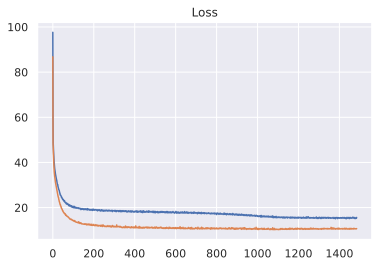

In [214]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show()

In [68]:
model.load_weights(PATH + 'best_model.hdf5')
model.save(DATA_PATH + 'nn_1.hdf5')

In [69]:
test_predict_nn1 = model.predict(X_test)
# test_predict_nn1 = np.exp(model.predict(X_test)) # обратный логарифм добавлен

print(f"TEST mape: {(mape(y_test, test_predict_nn1[:,0]))*100:0.2f}%")

TEST mape: 10.61%


best mape -10.17% (лучший результат среди сетей  (10.88 на Kaggle)  
нужно дважды прогнать нейросеть NN1 для достижения лучшего результата.





In [70]:
sub_predict_nn1 = model.predict(X_sub)
sample_submission['price'] = sub_predict_nn1[:, 0]
sample_submission.to_csv(DATA_PATH + 'nn1_submission-best53.csv', index=False)

In [71]:
sample_submission['price']

0       5.649793e+05
1       2.487492e+06
2       6.128411e+05
3       4.679751e+05
4       2.661972e+06
            ...     
1666    1.036727e+06
1667    2.613961e+06
1668    1.487069e+06
1669    1.070016e+06
1670    1.044674e+06
Name: price, Length: 1671, dtype: float32

Рекомендации для улучшения Model 3:    
* В нейросеть желательно подавать данные с распределением, близким к нормальному, поэтому от некоторых числовых признаков имеет смысл взять логарифм перед нормализацией. Попробовали, но это не дало результата улучшения.

* Извлечение числовых значений из текста:
Парсинг признаков 'engineDisplacement', 'enginePower', 'Владение' для извлечения числовых значений - сделали.


* Cокращение размерности категориальных признаков
Признак name 'name' содержит данные, которые уже есть в других столбцах ('enginePower', 'engineDisplacement', 'vehicleTransmission'), поэтому эти данные можно удалить. Затем следует еще сильнее сократить размерность, например, выделив наличие xDrive в качестве отдельного признака. - - сделали.

# Model 4: NLP + Multiple Inputs

# Приступим к токенизации. 

## ВАРИАНТ 1

### Сперва создадим список СТОП слов (загрузим его и дополним).
### Надо сделать  чистку Description и удалить все неважные слова. Сделаем Лемматизацию.

In [130]:
data.description

0       весь привет! продать эксклюзивный проект 124 у...
1       продавать любимый авто.. обвес тюнинг hamman. ...
2       авто продаваться первый раз, но! только что: п...
3       авто код5, весь родный краска ( краситься бамп...
4       немка! бесключивый доступ камера задний вида. ...
                              ...                        
8348    продаваться любимый авто! за год эксплуатация ...
8349    купить официальный дилер г. третий владелец, в...
8350    торг месте. всё работает. сборка немецкая. рез...
8351    авто код5. 3-из авто семья , обслуживание проф...
8352    удлинённый заводский pullman база w140 (вообще...
Name: description, Length: 8353, dtype: object

In [131]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [132]:
stopwords = stopwords.words("russian")
stopwords

['и',
 'в',
 'во',
 'не',
 'что',
 'он',
 'на',
 'я',
 'с',
 'со',
 'как',
 'а',
 'то',
 'все',
 'она',
 'так',
 'его',
 'но',
 'да',
 'ты',
 'к',
 'у',
 'же',
 'вы',
 'за',
 'бы',
 'по',
 'только',
 'ее',
 'мне',
 'было',
 'вот',
 'от',
 'меня',
 'еще',
 'нет',
 'о',
 'из',
 'ему',
 'теперь',
 'когда',
 'даже',
 'ну',
 'вдруг',
 'ли',
 'если',
 'уже',
 'или',
 'ни',
 'быть',
 'был',
 'него',
 'до',
 'вас',
 'нибудь',
 'опять',
 'уж',
 'вам',
 'ведь',
 'там',
 'потом',
 'себя',
 'ничего',
 'ей',
 'может',
 'они',
 'тут',
 'где',
 'есть',
 'надо',
 'ней',
 'для',
 'мы',
 'тебя',
 'их',
 'чем',
 'была',
 'сам',
 'чтоб',
 'без',
 'будто',
 'чего',
 'раз',
 'тоже',
 'себе',
 'под',
 'будет',
 'ж',
 'тогда',
 'кто',
 'этот',
 'того',
 'потому',
 'этого',
 'какой',
 'совсем',
 'ним',
 'здесь',
 'этом',
 'один',
 'почти',
 'мой',
 'тем',
 'чтобы',
 'нее',
 'сейчас',
 'были',
 'куда',
 'зачем',
 'всех',
 'никогда',
 'можно',
 'при',
 'наконец',
 'два',
 'об',
 'другой',
 'хоть',
 'после',
 'на

In [133]:
len(stopwords)

151

In [134]:
# Дополним список СТОП слов (можно добавить любые слова):
stopwords.extend(['что', 'это', '2017', 'вот', 'быть', 'как', 'в', '•', 'и', 'с', 'на', 'не', 'по', 'все',
                  'для', 'от', 'в', 'до', 'при', 'у', '2', 'без', 'за','то', 'есть', '1', 'года', 'только', '6',
                  'км', 'лет', '3', 'а', 'мы', '9' , 'вас', '5', '–', 'м', '∙', 'я', 'ваш', '4', 'вы', '7', 
                  'm', 'к', '00', 'год', '10', '8', '—','л', 'всех', 'in', 'о', 'руб', 'т', 'же', 'ни',  'под',
                  'можете', 'была', 'д', 'тыс', '0', 's', 'час', 'вся', 'всё', 'наш', 'г', '30', '11', 'если',
                  'возможна', 'это', 'предложение', 'рублей', 'себя', '☑️', 'нам', '50',  'ин', 'c', 'во', '✔',
 'х', '➥', '40', 'ряд', 'этого', '2018', '13', '●', 'эл', 'ти', '25', 'могу', '01', 'fi', '·', '2014', '✅',
  'ещё', 'кредиту', 'й', 'дверь', 'б', 'позвоните', '72', 'гк', 'сел', 'поехал', 'ооо', '☛', 'раз', 'i', '60',
   'р', 'кто', 'тд', '2013', 'мне', 'там', 'информации', '2016', 'лицо', 'еще',  '2012', 'оф'
 ])

In [135]:
len(stopwords)

282

In [136]:
def filter_str(st):
    # Фильтруем стоп-слова в Desrciption:
    split_str = st.split()
    filtered_str = ' '.join((filter(lambda s: s not in stopwords, split_str)))
    return filtered_str


data['description_filtered'] = data['description'].apply(filter_str)

In [137]:
data['description_filtered'].unique()

array(['весь привет! продать эксклюзивный проект 124 универсал 300te-24 sportline модель 124.091 300 te-24 двигатель 104.980 трансмиссия 722.359 цвет кузов 040 (черный) отделка салон 271 (кожа чёрный / "антрацит") опции: 211 автоматический блокировка дифференциал (asd) 240 индикатор внешний температура 244 спортивный сидение спереди 281 спортивный рулевой колесо отделка кожа (диаметр 390 мм) кожаный рычаг кпп 291 код16 водитель передний пассажир 300 дополнительный бардачок вещевой отсек спереди 412 люк электропривод устройство подъём 420 автоматический коробка передач, напольный исполнение 440 темпомат (круиз-контроль) 538 автоматический антенна 541 двойной занавеска багажный пространство пасажирский отсек (сетка/шторка) 570 складный подлокотник спереди 586 кондиционер behr электрический стеклоподъёмник передний задний 598 атермальный боковой задний стекла, задний стекло подогрев (esg) 650 спортивный подвеска 673 акб увеличить мощность 812 установленный сзади динамика 873 электрообогре

In [138]:
data['description'] = data['description_filtered']
data['description']

0       весь привет! продать эксклюзивный проект 124 у...
1       продавать любимый авто.. обвес тюнинг hamman. ...
2       авто продаваться первый раз, но! что: перебрат...
3       авто код5, весь родный краска ( краситься бамп...
4       немка! бесключивый доступ камера задний вида. ...
                              ...                        
8348    продаваться любимый авто! эксплуатация авто ве...
8349    купить официальный дилер г. третий владелец, в...
8350    торг месте. работает. сборка немецкая. резина ...
8351    авто код5. 3-из авто семья , обслуживание проф...
8352    удлинённый заводский pullman база w140 (вообще...
Name: description, Length: 8353, dtype: object

In [139]:
def preprocess_text(sen):
    # Removing html tags
    #sentence = remove_tags(sen)
    sentence = sen
    # Remove punctuations and numbers
    #sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ',  sentence)

    return sentence

In [140]:
data['description2'] = data['description'].apply(preprocess_text)

In [141]:
data['description2'][2]

'авто продаваться первый раз, но! что: перебрать двигатель замена колец, колпаков, ванос, цепь, прокладь др. покрасить вся, кроме багажник крыша (причина покраска - потёртость сколы, битая) сделать работа ходовой (рычаги, амортизатор др) поменять масло акпп раздатка вырезать катализатор (немного рычит) куча мелкий работ, обновление прошивки. тех, хотеть вкладывать деньги! общий стоимость работа составить 300 000 рублей. документ сервиса. хороший комплектация : кожа, полный привод!, датчик дождь света, помощь спуск горки. установить штатный медиасистема экран +камера задний вида. минус : рычать низах, удаление катов( легко исправить, многий нравится) ошибка корректор фара (нужный поменять датчики, фара работают) авто подвоха! идеальный внешний вид прекрасный технический состояние! торг минимальный.'

In [142]:
data['description'].nunique()

7625

Сделаем лемматизацию текста в признаке data['description']


In [143]:
# импортируем библиотеку для лемматизации на РУССКОМ
#!pip install pymorphy2
# и словарь подгружаем РУССКОМ
#!pip install -U pymorphy2-dicts-ru

In [144]:
# пример работы модуля
import pymorphy2
morph = pymorphy2.MorphAnalyzer()
word = morph.parse('доллар')[0]
v1, v2, v3 = word.inflect({'sing', 'nomn'}), word.inflect(
    {'gent'}), word.inflect({'plur', 'gent'})

print(v1.word, v2.word, v3.word)  # доллар доллара долларов

доллар доллара долларов


In [145]:
data['description'][111]

'комплектация: панорамный крыша, камера задний вида, навигационный система, проэкция лобовой стекло, спорт сидение , внешний пакет , руль. код5, доступный цена. тойота центр кунцево официальный дилер! представить 600 авто пробег 500 комплект шин, дисков, колесо сборе. подготовить несколько акций: акция №1 максимально выгодный кредит авто пробег 9,5% (одобрение 2х часов, минимальный комплект документов), сделка день день. + бонус 000 руб. банки-партнеры: 1. банк втб (пао) 2. «русфинанс банк» 3. ао «кредит европа банк (россия)» 4. пао "банк уралсиб" 5. ао «юникредит банк» 6. «фольксваген банк рус» 7. пао "совкомбанк" 8. ао «тойота банк» 9. ао «мс банк рус» 10. банк зенит (пао) 11. «сетель банк» 12. кб «локо-банк» (ао) 13. ао "рн банк" 14. пао "росгосстрах банк" акция №2 сдать свой авто - компенсировать 10% максимальный выгода 000 руб. акция №3 сделать то, слесарный кузовной ремонт приобретать авто пробег скидка 50%! ___________________________________________________________ авто прошли:

In [146]:
morph = pymorphy2.MorphAnalyzer()


def filter_str(str):
  # лемматизации текста (фильтрование):
    split_str = str.split()
    filtered_str = ' '.join(
        (map(lambda s: morph.parse(s)[0].normal_form, split_str)))
    return filtered_str


data['description'] = data['description'].apply(filter_str)
data['description']

0       весь привет! продать эксклюзивный проект 124 у...
1       продавать любимый авто.. обвес тюнинг hamman. ...
2       авто продаваться первый раз, но! что: перебрат...
3       авто код5, весь родный краска ( краситься бамп...
4       немка! бесключивыя доступ камера задний вида. ...
                              ...                        
8348    продаваться любимый авто! эксплуатация авто ве...
8349    купить официальный дилер г. третий владелец, в...
8350    торг месте. работает. сборка немецкая. резина ...
8351    авто код5. 3-из авто семья , обслуживание проф...
8352    удлинённый заводский pullman база w140 (вообще...
Name: description, Length: 8353, dtype: object

In [147]:
# вариант 2 фильтрования pymorphy2:
# """
# def to_normal_form(string):
#    return morph.parse(string)[0].normal_form
# def filter_str(str):
#    split_str = [to_normal_form(token) for token in str.split()]
#   filtered_str = ' '.join(split_str)
#    return filtered_str
# """"

Для эффективной фильтрации  текста можно использовать замену "хороших выражений"/слов на ключи для дальнейшей фильтрации и токенизации.

In [148]:
# Заменим самые частые слова и выражения на коды для уменьшения текста и улучшения токенизации:
# При желании можно разработать более детальный список "выражений" для замены на категории.

data['description'] = data['description'].apply(lambda s: s.replace('машина', 'авто'))
data['description'] = data['description'].apply(lambda s: s.replace('тачилу', 'авто'))
data['description'] = data['description'].apply(lambda s: s.replace('тачка', 'авто'))
data['description'] = data['description'].apply(lambda s: s.replace('автомобиль', 'авто'))
data['description'] = data['description'].apply(lambda s: s.replace('состоянии', 'состояние'))
data['description'] = data['description'].apply(lambda s: s.replace('официальный дилера', 'код1'))
data['description'] = data['description'].apply(lambda s: s.replace('оф. дилер', 'код1'))
data['description'] = data['description'].apply(lambda s: s.replace('гарантия производитель', 'код2'))
data['description'] = data['description'].apply(lambda s: s.replace('сервисный книжка', 'код3'))
data['description'] = data['description'].apply(lambda s: s.replace('гаражный хранение', 'код4'))
data['description'] = data['description'].apply(lambda s: s.replace('хороший состояние', 'код5'))
data['description'] = data['description'].apply(lambda s: s.replace('отличный состояние', 'код5'))
data['description'] = data['description'].apply(lambda s: s.replace('идеальный состояние', 'код5'))
data['description'] = data['description'].apply(lambda s: s.replace('птс оригинал', 'код6'))
data['description'] = data['description'].apply(lambda s: s.replace('добрый день', 'код7'))
data['description'] = data['description'].apply(lambda s: s.replace('рулевой колонка управление', 'код8'))
data['description'] = data['description'].apply(lambda s: s.replace('электрорегулировка сидение пассажир', 'код9'))
data['description'] = data['description'].apply(lambda s: s.replace('ваш удобства', 'код10'))
data['description'] = data['description'].apply(lambda s: s.replace('центральный замок', 'код11'))
data['description'] = data['description'].apply(lambda s: s.replace('доводчик дверей', 'код12'))
data['description'] = data['description'].apply(lambda s: s.replace('Климат-контроль', 'код13'))
data['description'] = data['description'].apply(lambda s: s.replace('вентиляция задний сидение', 'код14'))
data['description'] = data['description'].apply(lambda s: s.replace('система контроль слепой зона', 'код15'))
data['description'] = data['description'].apply(lambda s: s.replace('подушка безопасность', 'код16'))
data['description'] = data['description'].apply(lambda s: s.replace('широкий ассортимент', 'код17'))
data['description'] = data['description'].apply(lambda s: s.replace('гарантия юридический чистота', 'код18'))
data['description'] = data['description'].apply(lambda s: s.replace('обмен ваш автомобиль', 'код19'))
data['description'] = data['description'].apply(lambda s: s.replace('Mercedes - Benz', 'код20'))
data['description'] = data['description'].apply(lambda s: s.replace('климат - контроль', 'код21'))
data['description'] = data['description'].apply(lambda s: s.replace('а / м', 'код22'))
data['description'] = data['description'].apply(lambda s: s.replace('круиз - контроль', 'код23'))
data['description'] = data['description'].apply(lambda s: s.replace('все автомобиль проходить', 'код24'))
data['description'] = data['description'].apply(lambda s: s.replace('камера задний вид"', 'код25'))
data['description'] = data['description'].apply(lambda s: s.replace('автомобиль проходить комплексный', 'код26'))
data['description'] = data['description'].apply(lambda s: s.replace('AVILON автомобиль пробег', 'код27'))
data['description'] = data['description'].apply(lambda s: s.replace('более 000 проверять автомобиль пробег гарантия год ждать вы сайт rolf - probeg мобильный приложение мой рольф', 'код28'))
data['description'] = data['description'].apply(lambda s: s.replace('подушка безопасность водитель', 'код29'))
data['description'] = data['description'].apply(lambda s: s.replace('система система курсовой устойчивость', 'код31'))
data['description'] = data['description'].apply(lambda s: s.replace('датчик свет датчик дождь', 'код32'))
data['description'] = data['description'].apply(lambda s: s.replace('подушка безопасность пассажир', 'код33'))
data['description'] = data['description'].apply(lambda s: s.replace('подогрев сидение водитель пассажир', 'код34'))
data['description'] = data['description'].apply(lambda s: s.replace('официальный дилер BMW', 'код35'))

# Вариант 2:
 Создадим список ХОРОШИХ слов\ выражений (нужно хорошенько создать список слов, иначе ерунда будет!!!)

In [149]:
# создаем список слов\ выражений:

goodwords = ('Антипробуксовочная система (ASR)', 'Система стабилизации (ESP)', 'Подушка безопасности водителя',
             'Крепление детского кресла (задний ряд) ISOFIX', 'Подушки безопасности оконные (шторки)', 'Подушка безопасности пассажира',
             'Подушки безопасности боковые задние', 'Подушки безопасности боковые', 'Датчик давления в шинах',
             'Антиблокировочная система (ABS)', 'Блокировка замков задних дверей', 'Подушка безопасности для защиты коленей водителя',
             'Система «старт-стоп»', 'Электростеклоподъёмники передние', 'Мультифункциональное рулевое колесо', 'Прикуриватель и пепельница',
             'Бортовой компьютер', 'Усилитель руля', 'Электропривод зеркал', 'Электростеклоподъёмники задние', 'Парктроник передний',
             'Регулировка руля по вылету', 'Климат-контроль 2-зонный', 'Электроскладывание зеркал', 'Парктроник задний', 'AUX', 'USB',
             'Аудиосистема', 'Bluetooth', 'Датчик света', 'Автоматический корректор фар', 'Омыватель фар', 'Датчик дождя',
             'Электрообогрев боковых зеркал', 'Светодиодные фары', 'Регулировка передних сидений по высоте', 'Передний центральный подлокотник',
             'Складывающееся заднее сиденье', 'Электрорегулировка передних сидений', 'Тёмный салон', 'Кожа (Материал салона)',
             'Обогрев рулевого колеса', 'Подогрев передних сидений', 'Отделка кожей рулевого колеса', 'Центральный замок', 'Иммобилайзер',
             'Круиз-контроль', 'Система автоматической парковки', 'Камера задняя', 'Активный усилитель руля',
             'Климат-контроль многозонный', 'Система доступа без ключа', 'Запуск двигателя с кнопки', 'Электропривод крышки багажника',
             'Регулировка руля по высоте', 'Система помощи при торможении (BAS, EBD)', 'ЭРА-ГЛОНАСС',
             'Система помощи при старте в гору (HSA)', 'Аудиосистема Hi-Fi', 'Розетка 12V', 'Спортивные передние сиденья',
             'Декоративная подсветка салона', 'Накладки на пороги', 'Комбинированный (Материал салона)', 'Третий задний подголовник',
             'Электрообогрев форсунок стеклоомывателей', 'Дневные ходовые огни', 'Противотуманные фары', 'Диски 18', 'Металлик',
             'Открытие багажника без помощи рук', 'Доводчик дверей', 'Проекционный дисплей', 'Дистанционный запуск двигателя',
             'Электронная приборная панель', 'Климат-контроль 1-зонный', 'Система адаптивного освещения', 'Система управления дальним светом',
             'Электрообогрев лобового стекла', 'Навигационная система', 'Беспроводная зарядка для смартфона',
             'Мультимедиа система для задних пассажиров', 'Голосовое управление', 'Люк',
             'Подогрев задних сидений', 'Память передних сидений', 'Вентиляция передних сидений', 'Количество мест: 5',
             'Вентиляция задних сидений', 'Светлый салон', 'Подрулевые лепестки переключения передач', 'Ксеноновые/Биксеноновые фары',
             'Диски 19', 'Электрорегулировка руля', 'Камера 360°', 'Аудиоподготовка', 'Прочее',
             'Защита картера', 'Ткань (Материал салона)', 'Тонированные стекла', 'Панорамная крыша / лобовое стекло',
             'Рейлинги на крыше', 'Легкосплавные диски', 'Диски 17', 'Сигнализация', 'Докатка', 'Отделка кожей рычага КПП',
             'Электрообогрев зоны стеклоочистителей', 'Рулевая колонка с памятью положения', 'Диски 20', 'Аудиосистема с TV',
             'Датчик проникновения в салон (датчик объема)', 'Декоративные молдинги', 'Полноразмерное запасное колесо',
             'Количество мест: 4', 'Активная подвеска', 'Электрорегулировка сиденья водителя', 'Регулировка сиденья водителя по высоте',
             'Память сиденья водителя', 'Система помощи при спуске', 'Охлаждаемый перчаточный ящик',
             'Датчик усталости водителя', 'Функция складывания спинки сиденья пассажира', 'Солнцезащитная шторка на заднем стекле',
             'Солнцезащитные шторки в задних дверях', 'Сиденья с массажем', 'CarPlay', 'Программируемый предпусковой отопитель',
             'Отделка потолка чёрной тканью', 'Декоративные накладки на педали', 'Обвес кузова',
             'Количество мест: 2', 'Стальные диски', 'Крепление детского кресла (передний ряд) ISOFIX', 'Адаптивный круиз-контроль',
             'Система выбора режима движения', 'Искусственная кожа (Материал салона)', 'Диски 16', 'Система контроля за полосой движения',
             'Система предотвращения столкновения', 'Система контроля слепых зон',
             'Третий ряд сидений', 'Диски 21', 'Пневмоподвеска', 'Кондиционер', 'Регулируемый педальный узел',
             'Система распознавания дорожных знаков', 'Система ночного видения',
             'Электрорегулировка задних сидений', 'Лазерные фары', 'Спортивная подвеска', 'Система стабилизации рулевого управления (VSM)',
             'Android Auto', 'Розетка 220V', 'Фаркоп', 'Диски 15',  'Диски 22', 'Количество мест: 7', 'Алькантара (Материал салона)',
             'Яндекс.Авто', 'Сигнализация с обратной связью', 'Складной столик на спинках передних сидений', 'Велюр (Материал салона)',
             'Ламинированные боковые стекла', 'Бронированный кузов', 'Аэрография', 'Камера передняя', 'Количество мест: 6',
             'Газобаллонное оборудование', 'Диски 14')

In [150]:
# cделаем разбивку Хороших слов на отдельные слов:
new_list = []
for st in goodwords:
    split_str = st.split()
    new_list.append(split_str)

In [151]:
def listmerge1(lstlst):
    # приведем к единому списку шороших слов:
    all = []
    for lst in lstlst:
        for el in lst:
            all.append(el)
    return all


goodlist = listmerge1(new_list)

In [152]:
# сделаем все с маленькой буквы:
new_list_low = []
for word in goodlist:
    word1 = word.lower()
    new_list_low.append(word1)

In [153]:
new_list_low

['антипробуксовочная',
 'система',
 '(asr)',
 'система',
 'стабилизации',
 '(esp)',
 'подушка',
 'безопасности',
 'водителя',
 'крепление',
 'детского',
 'кресла',
 '(задний',
 'ряд)',
 'isofix',
 'подушки',
 'безопасности',
 'оконные',
 '(шторки)',
 'подушка',
 'безопасности',
 'пассажира',
 'подушки',
 'безопасности',
 'боковые',
 'задние',
 'подушки',
 'безопасности',
 'боковые',
 'датчик',
 'давления',
 'в',
 'шинах',
 'антиблокировочная',
 'система',
 '(abs)',
 'блокировка',
 'замков',
 'задних',
 'дверей',
 'подушка',
 'безопасности',
 'для',
 'защиты',
 'коленей',
 'водителя',
 'система',
 '«старт-стоп»',
 'электростеклоподъёмники',
 'передние',
 'мультифункциональное',
 'рулевое',
 'колесо',
 'прикуриватель',
 'и',
 'пепельница',
 'бортовой',
 'компьютер',
 'усилитель',
 'руля',
 'электропривод',
 'зеркал',
 'электростеклоподъёмники',
 'задние',
 'парктроник',
 'передний',
 'регулировка',
 'руля',
 'по',
 'вылету',
 'климат-контроль',
 '2-зонный',
 'электроскладывание',
 'зерка

In [154]:
data['description'][345]

'выпуска: 2016. пробег: 000 км. кузов: седан. цвет: белый. двигатель: 3.0 / 265 л.с. / дизель. налог: 39 750 ₽ / год. коробка: автоматическая. привод: полный. руль: левый. состояние: требовать ремонта. владельцы: более. птс: оригинал. таможня: растаможен. vin: wba**************. госномер: ******|750.'

In [155]:
def filter_str(st):
    # фильтруем Хорошие слова по списку  в Desrciption (надо доработать, чтобы выражения отсеивал!!!!)
    split_str = st.split()
    filtered_str = ' '.join((filter(lambda s: s in new_list_low, split_str)))
    return filtered_str


data['description_filtered3'] = data['description'].apply(filter_str)

###  Выбираем вариант 1 по фильтрации текста (т.к. он показал лучше результат) (со СТОП-списком)

In [156]:
#data['description'] = data['description_filtered3']

In [157]:
# TOKENIZER
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 50000  # 10000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 200

In [158]:
# split данных
text_train = data.description.iloc[X_train.index]
text_test = data.description.iloc[X_test.index]
text_sub = data.description.iloc[X_sub.index]

In [159]:
text_train

4112    авто код5 свой лет. кузов окелейный плёнкой. д...
6339    владелец. оригинальный пробег. идеальный внешн...
7503    факт владелец , из-за перевес , документ идти ...
6710    покупать знакомого, качественный своевременный...
7691    воздух покупатель последний деньга авто вас. т...
                              ...                        
5443    код5...!!! красить детали...!!! оригинальный п...
6862    рольф премиум крупный официальный дилер москва...
6897    s-lin аlkantara код5, сидeние пaмятью, пoдсвeт...
7061    продаваться собственником. птс хозяин. гаранти...
2531    «inchcape certified- первый международный офиц...
Name: description, Length: 6114, dtype: object

### Tokenizer

In [160]:
# Приступим к самой токенизации. 

In [161]:
#% % time
tokenize = Tokenizer(num_words=MAX_WORDS,
                     #filters='!"#$&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
                     )
tokenize.fit_on_texts(data.description)

In [162]:
dir(tokenize)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_keras_api_names',
 '_keras_api_names_v1',
 'char_level',
 'document_count',
 'filters',
 'fit_on_sequences',
 'fit_on_texts',
 'get_config',
 'index_docs',
 'index_word',
 'lower',
 'num_words',
 'oov_token',
 'sequences_to_matrix',
 'sequences_to_texts',
 'sequences_to_texts_generator',
 'split',
 'texts_to_matrix',
 'texts_to_sequences',
 'texts_to_sequences_generator',
 'to_json',
 'word_counts',
 'word_docs',
 'word_index']

In [163]:
tokenize.word_counts

OrderedDict([('весь', 986),
             ('привет', 15),
             ('продать', 577),
             ('эксклюзивный', 171),
             ('проект', 17),
             ('124', 7),
             ('универсал', 30),
             ('300te', 1),
             ('24', 133),
             ('sportline', 6),
             ('модель', 153),
             ('091', 1),
             ('300', 99),
             ('te', 1),
             ('двигатель', 1830),
             ('104', 3),
             ('980', 3),
             ('трансмиссия', 26),
             ('722', 6),
             ('359', 2),
             ('цвет', 1119),
             ('кузов', 1529),
             ('040', 1),
             ('черный', 117),
             ('отделка', 944),
             ('салон', 5308),
             ('271', 8),
             ('кожа', 1378),
             ('чёрный', 1438),
             ('антрацит', 229),
             ('опции', 65),
             ('211', 31),
             ('автоматический', 1275),
             ('блокировка', 280),
             (

In [164]:
# Попытка отсортировать 200 самых частых слов по тексту.
list_d = sorted(tokenize.word_counts)
list_shot = list_d
list_shot

["''авангард''",
 "''жемчужный",
 "'carbon",
 "'comfort'",
 "'craftedclarity'",
 "'dakota'",
 "'fineline",
 "'fineline'",
 "'grey",
 "'hexagon'",
 "'mercedes",
 "'merino'",
 "'micro",
 "'nappa'",
 "'trigon'",
 "'vernasca'",
 "'липучке'",
 "'оксид",
 "'подводный",
 "'чёрный",
 '0',
 '00',
 '000',
 '00071',
 '00096',
 '000km',
 '000км',
 '000назад',
 '000р',
 '000руб',
 '000т',
 '000тыс',
 '000ь',
 '000₽',
 '001',
 '002',
 '00296',
 '003',
 '004663',
 '005',
 '006',
 '00627',
 '00676',
 '007',
 '00780',
 '008',
 '009',
 '00до21',
 '00₽',
 '01',
 '01045305',
 '01091178',
 '01100498',
 '01136790',
 '01147932',
 '01162597',
 '01186863',
 '01190546',
 '01190547',
 '01190807',
 '01193694',
 '01197222',
 '01199303',
 '012',
 '01200668',
 '01203937',
 '01204655',
 '01206013',
 '01207262',
 '01208504',
 '01208633',
 '01209152',
 '01209196',
 '01209457',
 '01209572',
 '01209632',
 '01210234',
 '01210388',
 '01210445',
 '01210494',
 '01210637',
 '01210858',
 '01210909',
 '01210924',
 '01211732',
 

In [165]:
tokenize.word_index

{'авто': 1,
 'система': 2,
 'задний': 3,
 'пробег': 4,
 'салон': 5,
 'передний': 6,
 'сидение': 7,
 'комплект': 8,
 'кредит': 9,
 'диск': 10,
 'новый': 11,
 'код5': 12,
 'пакет': 13,
 'фара': 14,
 'официальный': 15,
 'руль': 16,
 'колесо': 17,
 'дилер': 18,
 'состояние': 19,
 'обмен': 20,
 'комплектация': 21,
 'контроль': 22,
 'bmw': 23,
 '000': 24,
 'полный': 25,
 'покупка': 26,
 'зеркало': 27,
 'продажа': 28,
 'автомобиля': 29,
 'шина': 30,
 'двигатель': 31,
 'любой': 32,
 'обогрев': 33,
 'проверка': 34,
 'обслуживание': 35,
 'код16': 36,
 'технический': 37,
 'резина': 38,
 'гарантия': 39,
 'птс': 40,
 'торг': 41,
 'масло': 42,
 'водитель': 43,
 'замена': 44,
 'владелец': 45,
 'условие': 46,
 'рулевой': 47,
 'кузов': 48,
 'климат': 49,
 'купить': 50,
 'стекло': 51,
 '2': 52,
 'подогрев': 53,
 'оригинальный': 54,
 'дтп': 55,
 'чёрный': 56,
 'дополнительный': 57,
 'электропривод': 58,
 'пройти': 59,
 'зимний': 60,
 'проверить': 61,
 'каждый': 62,
 'кожа': 63,
 '9': 64,
 'amg': 65,
 'ро

In [166]:
len(tokenize.word_index)

31705

In [167]:
#%% time
text_train_sequences = sequence.pad_sequences(
    tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(
    tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(
    tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape,
      text_test_sequences.shape, text_sub_sequences.shape, )

(6114, 200) (568, 200) (1671, 200)


In [168]:
text_train_sequences

array([[   0,    0,    0, ...,  436,  953, 2759],
       [   0,    0,    0, ...,   11,   38, 1990],
       [   0,    0,    0, ..., 3743, 1050,  901],
       ...,
       [   0,    0,    0, ..., 3214,   11, 5269],
       [   0,    0,    0, ...,   38,   54,  414],
       [   0,    0,    0, ...,    8,  909,  226]], dtype=int32)

In [169]:
# вот так теперь выглядит наш текст:
print(text_train.iloc[6])
print(text_train_sequences[6])

авто код5, вопрос телефону. работает, комплект колес, торг уместен. перекупщик салон беспокоить, помощь продажа авто нуждаюсь. недостаток - трещина лобовой стекле. (коробка перебрать назад,поменять радиатор,помпу,крышка прокладками,пневму,свечи,катушки,колодка диск зад ,ризин зима лето новый масло bardahl.
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     

### RNN NLP

In [170]:
model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
model_nlp.add(L.LSTM(300, return_sequences=True))
model_nlp.add(L.Dropout(0.6))  # 0.4
# model_nlp.add(L.BatchNormalization()) 
model_nlp.add(L.LSTM(128,))
model_nlp.add(L.Dropout(0.45))
model_nlp.add(L.Dense(64, activation="relu"))
model_nlp.add(L.Dropout(0.25))

### MLP

In [171]:
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.8))
model_mlp.add(L.Dense(300, activation="relu"))  # 256
model_mlp.add(L.Dropout(0.6))

### Multiple Inputs NN

In [172]:
# можно проверить модель только с тектсом (без MLP)!!!! - хуже результат!!!

In [173]:
combinedInput = L.concatenate([model_nlp.output, model_mlp.output])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)
model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

In [174]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_description (InputLayer)    [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 200, 200)     6341200     seq_description[0][0]            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 200, 300)     601200      embedding_1[0][0]                
__________________________________________________________________________________________________
dropout_247 (Dropout)           (None, 200, 300)     0           lstm_2[0][0]                     
_______________________________________________________________________________________

### Fit

In [175]:
optimizer = tf.keras.optimizers.Adamax(0.005)  # 0.003 Adamax Adam
model.compile(loss='MAPE', optimizer=optimizer, metrics=['MAPE'])

In [176]:
checkpoint = ModelCheckpoint('best_model.hdf5', monitor=[
                             'val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(
    monitor='val_MAPE', patience=20, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [177]:
history = model.fit([text_train_sequences, X_train], y_train,
                    batch_size=512,
                    epochs=700,  # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list
                    )

Epoch 1/700
12/12 [==============================] - 3s 248ms/step - loss: 99.9954 - MAPE: 99.9954 - val_loss: 99.9805 - val_MAPE: 99.9805
Epoch 2/700
12/12 [==============================] - 2s 174ms/step - loss: 99.9311 - MAPE: 99.9311 - val_loss: 99.8299 - val_MAPE: 99.8299
Epoch 3/700
12/12 [==============================] - 2s 184ms/step - loss: 99.6278 - MAPE: 99.6278 - val_loss: 99.2588 - val_MAPE: 99.2588
Epoch 4/700
12/12 [==============================] - 2s 168ms/step - loss: 98.6640 - MAPE: 98.6640 - val_loss: 97.7077 - val_MAPE: 97.7077
Epoch 5/700
12/12 [==============================] - 2s 173ms/step - loss: 96.3163 - MAPE: 96.3163 - val_loss: 94.2109 - val_MAPE: 94.2109
Epoch 6/700
12/12 [==============================] - 2s 169ms/step - loss: 91.3870 - MAPE: 91.3870 - val_loss: 87.3534 - val_MAPE: 87.3534
Epoch 7/700
12/12 [==============================] - 2s 177ms/step - loss: 82.1842 - MAPE: 82.1842 - val_loss: 75.1018 - val_MAPE: 75.1018
Epoch 8/700
12/12 [========

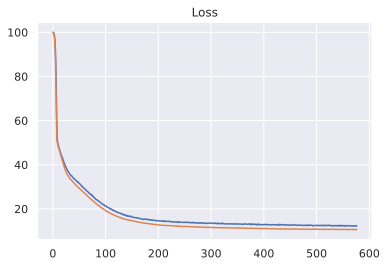

In [178]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show()

In [179]:
model.load_weights('best_model.hdf5')
model.save(DATA_PATH+ 'nn_mlp_nlp.hdf5')

In [180]:
test_predict_nn2 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape(y_test, test_predict_nn2[:,0]))*100:0.2f}%")

TEST mape: 10.67%


best = 10.73%

In [181]:
sub_predict_nn2 = model.predict([text_sub_sequences, X_sub])
sample_submission['price'] = sub_predict_nn2[:, 0]
sample_submission.to_csv(DATA_PATH + 'nn2_submission3.csv', index=False)

Идеи для улучшения NLP части:
* Выделить из описаний часто встречающиеся блоки текста, заменив их на кодовые слова или удалив
* Сделать предобработку текста, например, сделать лемматизацию - алгоритм ставящий все слова в форму по умолчанию (глаголы в инфинитив и т. д.), чтобы токенайзер не преобразовывал разные формы слова в разные числа
Статья по теме: https://habr.com/ru/company/Voximplant/blog/446738/
* Поработать над алгоритмами очистки и аугментации текста

# Model 5: Добавляем картинки

### Data

In [182]:
import zipfile
import PIL
from PIL import ImageOps, ImageFilter

print('Распаковываем картинки')
# Will unzip the files so that you can see them.
for data_zip in ['img.zip']:
    with zipfile.ZipFile(DATA_PATH + data_zip, "r") as z:
        z.extractall(PATH)

print(os.listdir(PATH))

Распаковываем картинки
['.config', 'catboost_info', '__MACOSX', 'img', 'best_model.hdf5', 'requirements.txt', 'drive', 'sample_data']


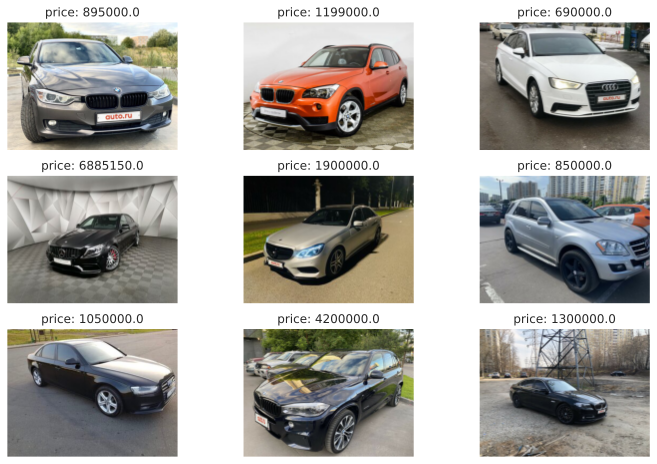

In [183]:
# убедимся, что цены и фото подгрузились верно
plt.figure(figsize=(12, 8))

random_image = train.sample(n=9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(PATH + "/img/img/" + str(path) + ".jpg")
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

In [184]:
size = (320, 240)  # (320, 240)- виснет:(480, 360)


def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(data['sell_id'].iloc[index].values):
        image = cv2.imread("/content/img/img/" + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)


images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(X_sub.index)

images shape (6114, 240, 320, 3) dtype uint8
images shape (568, 240, 320, 3) dtype uint8
images shape (1671, 240, 320, 3) dtype uint8


### albumentations

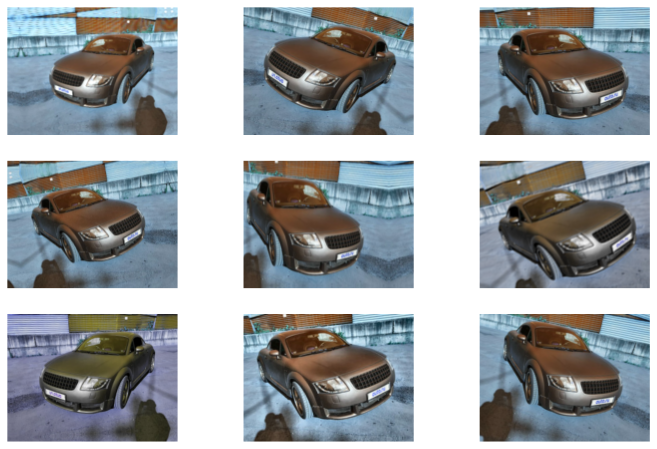

In [185]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)


# пример взят из официальной документации: https://albumentations.readthedocs.io/en/latest/examples.html
augmentation = Compose([
    HorizontalFlip(),
    OneOf([
        IAAAdditiveGaussianNoise(),
        GaussNoise(),
    ], p=0.3),
    OneOf([
        MotionBlur(p=0.2),
        MedianBlur(blur_limit=3, p=0.2),
        Blur(blur_limit=3, p=0.1),
    ], p=0.2),
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2,
                     rotate_limit=15, p=1),
    OneOf([
        OpticalDistortion(p=0.3),
        GridDistortion(p=0.2),
        IAAPiecewiseAffine(p=0.3),
    ], p=0.2),
    OneOf([
        CLAHE(clip_limit=2),
        IAASharpen(),
        IAAEmboss(),
        RandomBrightnessContrast(),
    ], p=0.3),
    HueSaturationValue(p=0.3),
], p=1)

# пример
plt.figure(figsize=(12, 8))
for i in range(9):
    img = augmentation(image=images_train[0])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [186]:
def make_augmentations(images):
    print('применение аугментаций', end='')
    augmented_images = np.empty(images.shape)
    for i in range(images.shape[0]):
        if i % 200 == 0:
            print('.', end='')
        augment_dict = augmentation(image=images[i])
        augmented_image = augment_dict['image']
        augmented_images[i] = augmented_image
    print('')
    return augmented_images

## tf.data.Dataset
Если все изображения мы будем хранить в памяти, то может возникнуть проблема ее нехватки. Не храните все изображения в памяти целиком!

Метод .fit() модели keras может принимать либо данные в виде массивов или тензоров, либо разного рода итераторы, из которых наиболее современным и гибким является [tf.data.Dataset](https://www.tensorflow.org/guide/data). Он представляет собой конвейер, то есть мы указываем, откуда берем данные и какую цепочку преобразований с ними выполняем. Далее мы будем работать с tf.data.Dataset.

Dataset хранит информацию о конечном или бесконечном наборе кортежей (tuple) с данными и может возвращать эти наборы по очереди. Например, данными могут быть пары (input, target) для обучения нейросети. С данными можно осуществлять преобразования, которые осуществляются по мере необходимости ([lazy evaluation](https://ru.wikipedia.org/wiki/%D0%9B%D0%B5%D0%BD%D0%B8%D0%B2%D1%8B%D0%B5_%D0%B2%D1%8B%D1%87%D0%B8%D1%81%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F)).

`tf.data.Dataset.from_tensor_slices(data)` - создает датасет из данных, которые представляют собой либо массив, либо кортеж из массивов. Деление осуществляется по первому индексу каждого массива. Например, если `data = (np.zeros((128, 256, 256)), np.zeros(128))`, то датасет будет содержать 128 элементов, каждый из которых содержит один массив 256x256 и одно число.

`dataset2 = dataset1.map(func)` - применение функции к датасету; функция должна принимать столько аргументов, каков размер кортежа в датасете 1 и возвращать столько, сколько нужно иметь в датасете 2. Пусть, например, датасет содержит изображения и метки, а нам нужно создать датасет только из изображений, тогда мы напишем так: `dataset2 = dataset.map(lambda img, label: img)`.

`dataset2 = dataset1.batch(8)` - группировка по батчам; если датасет 2 должен вернуть один элемент, то он берет из датасета 1 восемь элементов, склеивает их (нулевой индекс результата - номер элемента) и возвращает.

`dataset.__iter__()` - превращение датасета в итератор, из которого можно получать элементы методом `.__next__()`. Итератор, в отличие от самого датасета, хранит позицию текущего элемента. Можно также перебирать датасет циклом for.

`dataset2 = dataset1.repeat(X)` - датасет 2 будет повторять датасет 1 X раз.

Если нам нужно взять из датасета 1000 элементов и использовать их как тестовые, а остальные как обучающие, то мы напишем так:

`test_dataset = dataset.take(1000)
train_dataset = dataset.skip(1000)`

Датасет по сути неизменен: такие операции, как map, batch, repeat, take, skip никак не затрагивают оригинальный датасет. Если датасет хранит элементы [1, 2, 3], то выполнив 3 раза подряд функцию dataset.take(1) мы получим 3 новых датасета, каждый из которых вернет число 1. Если же мы выполним функцию dataset.skip(1), мы получим датасет, возвращающий числа [2, 3], но исходный датасет все равно будет возвращать [1, 2, 3] каждый раз, когда мы его перебираем.

tf.Dataset всегда выполняется в graph-режиме (в противоположность eager-режиму), поэтому либо преобразования (`.map()`) должны содержать только tensorflow-функции, либо мы должны использовать tf.py_function в качестве обертки для функций, вызываемых в `.map()`. Подробнее можно прочитать [здесь](https://www.tensorflow.org/guide/data#applying_arbitrary_python_logic).

In [187]:
# NLP part
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

In [188]:
size = (320, 240)

In [189]:
def process_image(image):
    return augmentation(image = image.numpy())['image']

def tokenize_(descriptions):
  return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions), maxlen = MAX_SEQUENCE_LENGTH)

def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]

def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

def tf_process_val_dataset_element(image, table_data, text, price):
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, data.description.iloc[X_train.index], y_train
    )).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, data.description.iloc[X_test.index], y_test
    )).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, X_sub, data.description.iloc[X_sub.index], y_sub
    )).map(tf_process_val_dataset_element)

#проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset.__iter__().__next__();
test_dataset.__iter__().__next__();
sub_dataset.__iter__().__next__();

### Строим сверточную сеть для анализа изображений без "головы"

Можно построить просто сеть для картинок\цена без multinput - но результат сильно хуже!!!

In [190]:
import tensorflow as tf
# Меняем модель  на EfficientNetB4 как более эффективную
# нормализация включена в состав модели EfficientNetB4, поэтому на вход она принимает данные типа uint8
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB4(
    weights='imagenet', include_top=False, input_shape=(size[1], size[0], 3))
efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

71688192/71686520 [==============================] - 5s 0us/step


Можно попробовать и другие сети,  в5, в6 ...

In [191]:
# строим нейросеть для анализа табличных данных
tabular_model = Sequential([
    L.Input(shape=X.shape[1]),
    L.Dense(512, activation='relu'),
    L.Dropout(0.8),
    L.BatchNormalization(),
    L.Dense(300, activation='relu'),
    L.Dropout(0.6),
])

In [192]:
# NLP
nlp_model = Sequential([
    L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"),
    L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,),
    L.LSTM(300, return_sequences=True),
    L.Dropout(0.7),
    L.LSTM(128),
    L.Dropout(0.45),
    L.Dense(64),
])

In [193]:
# объединяем выходы трех нейросетей
combinedInput = L.concatenate(
    [efficientnet_output, tabular_model.output, nlp_model.output])

# being our regression head
head = L.Dense(300, activation="relu")(combinedInput)  # combinedInput
L.Dropout(0.7)  # добавил
# head = L.Dense(128, activation="relu") # добавил
head = L.Dense(1,)(head)

# inputs=[efficientnet_model.input, tabular_model.input, nlp_model.input
model = Model(inputs=[efficientnet_model.input,
                      tabular_model.input, nlp_model.input], outputs=head)
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 320, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 240, 320, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 240, 320, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 241, 321, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

In [194]:
optimizer = tf.keras.optimizers.Adam(0.005)  # Adamax 0.005
model.compile(loss='MAPE', optimizer=optimizer, metrics=['MAPE'])

In [195]:
checkpoint = ModelCheckpoint('best_model.hdf5', monitor=[
                             'val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(
    monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [196]:
train_dataset

<MapDataset shapes: (((240, 320, 3), (431,), <unknown>), ()), types: ((tf.uint8, tf.float64, tf.int32), tf.float64)>

In [197]:
test_dataset

<MapDataset shapes: (((240, 320, 3), (431,), <unknown>), ()), types: ((tf.uint8, tf.float64, tf.int32), tf.float64)>

In [198]:
history = model.fit(train_dataset.batch(30),  # тут можно батчсайз  уменьшить  для В6
                    epochs=100,  # 100
                    # тут можно батчсайз  уменьшить  для В6
                    validation_data=test_dataset.batch(30),
                    callbacks=callbacks_list
                    )

Epoch 1/100
204/204 [==============================] - ETA: 0s - loss: 62.5283 - MAPE: 62.5283

KeyboardInterrupt: ignored

In [ ]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show()

In [ ]:
model.load_weights('best_model.hdf5')
model.save(DATA_PATH +'nn_final.hdf5')

In [ ]:
test_predict_nn3 = model.predict(test_dataset.batch(30))
print(f"TEST mape: {(mape(y_test, test_predict_nn3[:,0]))*100:0.2f}%")

best result =  15.01%

In [ ]:
sub_predict_nn3 = model.predict(sub_dataset.batch(30))
sample_submission['price'] = sub_predict_nn3[:, 0]
sample_submission.to_csv(DATA_PATH + 'nn3_submission1.csv', index=False)


#### Общие выводы:
* Сделали  обработку EDA и создали новые признаки (Feature engineering). Это улучшило  показатели MAPE на всех сетях.
* Извлечение числовых значений из текста сделали:
Парсинг признаков 'engineDisplacement', 'enginePower', 'Владение' для извлечения числовых значений.
* Cокращение размерности категориальных признаков также сделали.
* Попробовали разные архитектуры  сетей (игрались со слоями, кол-вом нейронов, разные активаторы и оптимизаторы использовали).
* Провели более детальный анализ результатов - лучше всего результат у сети  NN1 (нейросеть  на основе табличных данных).
* Попробовали различные подходы в управление LR и оптимизаторы (пробовали разные варианты,  остановились  на указанных в ноутбуке , как самые результативные).
*  Наилучший результат был достигнут на нейросети на табличных данных (NN1): MAPE =11.11204% (2-e место на соревнованиях).

#### NLP
* Сделали  чистку текста из описаний с помощью СТОП -списка, дополнили его.
* Разработали вариант выделения из описаний часто встречающиеся блоки текста,слов, с дальнейшей фильтрацией по нему. 
* Сделали предобработку текста, сделать лемматизацию - алгоритм ставящий все слова в форму по умолчанию (глаголы в инфинитив и т. д.), чтобы токенайзер не преобразовывал разные формы слова в разные числа.
* Поработали над алгоритмами очистки.  Аугментацию текста сделать не успели.



#### CV
* Заменили модель  B3 на более продвинутую В4.
* Fine-tuning - сделать не успели.

# Blend

Техника blend позволяет усреднять результаты сетей, добиваясь  лучшего результата. 

Возможна с использованием весов  (например: (blend = (0.3*predict1 + 0.7*predict2)/2).

Пробуем "блендить" сети в разных комбинациях:

In [ ]:
blend_predict = (test_predict_catboost + test_predict_nn1[:,0]) / 2  
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")


best result = 10.50 %

In [ ]:
blend_sub_predict = (sub_predict_catboost + sub_predict_nn1[:, 0]) / 2
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv(DATA_PATH + 'blend_submission17.csv', index=False)

In [ ]:
blend_predict = (test_predict_catboost + test_predict_nn2[:, 0]) / 2
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

best result =  11.00   %

In [ ]:
blend_sub_predict = (sub_predict_catboost + sub_predict_nn2[:, 0]) / 2
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv(DATA_PATH + 'blend_submission16.csv', index=False)

In [ ]:
blend_predict = (test_predict_nn2[:, 0] + test_predict_nn1[:, 0]) / 2
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

best result = 10.73    %

In [ ]:
blend_sub_predict = (sub_predict_nn2[:, 0] + sub_predict_nn1[:, 0]) / 2
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv(DATA_PATH + 'blend_submission18.csv', index=False)

In [ ]:
blend_predict = (test_predict_catboost + test_predict_nn3[:,0]) / 2
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

best result =     %

In [ ]:
blend_sub_predict = (sub_predict_catboost + sub_predict_nn3[:, 0]) / 2
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv(DATA_PATH + 'blend_submission19.csv', index=False)

In [207]:
blend_predict = (test_predict_catboost +
                 test_predict_nn2[:, 0] + test_predict_nn3[:, 0]) / 3
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

NameError: ignored

best result =     %

In [ ]:
blend_sub_predict = (sub_predict_catboost +
                     sub_predict_nn2[:, 0]+sub_predict_nn3[:, 0]) / 3
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv(DATA_PATH + 'blend_submission21.csv', index=False)

Делаем бленд лучших сетей с весами, больший вес для лучшей сети:

In [ ]:
blend_predict = (
    0.7*(test_predict_nn1[:, 0]) + 0.3*(test_predict_nn2[:, 0])) / 1
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

best result = 10.49    %

In [ ]:
blend_sub_predict = (0.7*sub_predict_nn1[:, 0] + 0.3*sub_predict_nn2[:, 0]) / 1
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv(DATA_PATH + 'blend_submission34.csv', index=False)

In [ ]:
blend_predict = (0.1*test_predict_catboost + 0.7 *
                 test_predict_nn1[:, 0]+0.2*test_predict_nn2[:, 0]) / 1
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

best result = 10.31    %

In [ ]:
blend_sub_predict = (0.1*sub_predict_catboost + 0.7 *
                     sub_predict_nn1[:, 0] + 0.2*sub_predict_nn2[:, 0]) / 1
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv(DATA_PATH + 'blend_submission35.csv', index=False)

Бленд результатов сабмишн особенно с весами показали себя как весьма интересный инструмент.

# Model Bonus: проброс признака
Также испробуем модель с проброской признака. В  данном случае возьмем productionDate как самый сильно коррелирующий с таргетом.

In [ ]:
# MLP
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.7))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.6))
model_mlp.add(L.Dense(128, activation="relu"))
model_mlp.add(L.Dropout(0.5))

In [ ]:
# FEATURE Input
# Input
productiondate = L.Input(shape=[1], name="productionDate")
# Embeddings layers
emb_productiondate = L.Embedding(
    len(X.productionDate.unique().tolist())+1, 20)(productiondate)
f_productiondate = L.Flatten()(emb_productiondate)

In [ ]:
combinedInput = L.concatenate([model_mlp.output, f_productiondate, ])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_mlp.input, productiondate], outputs=head)

In [ ]:
model.summary()

In [ ]:
optimizer = tf.keras.optimizers.Adamax(0.005)
model.compile(loss='MAPE', optimizer=optimizer, metrics=['MAPE'])

In [ ]:
history = model.fit([X_train, X_train.productionDate.values], y_train,
                    batch_size=512,
                    epochs=500,  # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=(
                        [X_test, X_test.productionDate.values], y_test),
                    callbacks=callbacks_list
                    )

In [ ]:
model.load_weights('best_model.hdf5')
test_predict_nn_bonus = model.predict([X_test, X_test.productionDate.values])
print(f"TEST mape: {(mape(y_test, test_predict_nn_bonus[:,0]))*100:0.2f}%")

best result =  10.51   %

In [ ]:
sub_predict_nn_bonus = model.predict([X_sub, X_sub.productionDate.values])
sample_submission['price'] = sub_predict_nn_bonus
sample_submission.to_csv(DATA_PATH + 'sub_predict_nn_bonus1.csv', index=False)

# Model 7. SUPER-BONUS:  Модель с созданием множества простых сетей со случайными весами

Создадим 120 случайных нейросетей на табличных данных (как показывающих самый лучший результат), а затем вычислим средний результат и  сделаем сабмишн.

In [ ]:
predictions = []
sub_predictions  = []
for i in range(120):
    model = Sequential()
    model.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu")) 
    model.add(L.Dropout(0.9))
    model.add(L.Dense(300, activation="relu"))
    model.add(L.Dropout(0.7))
    model.add(L.Dense(1, activation="linear"))
    optimizer = tf.keras.optimizers.Adam (0.004)
    model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])
    checkpoint = ModelCheckpoint('best_model.hdf5', monitor=[
                             'val_MAPE'], verbose=0, mode='min')
    earlystop = EarlyStopping(
    monitor='val_MAPE', patience=400, restore_best_weights=True,)
    callbacks_list = [checkpoint, earlystop]
    history = model.fit(X_train, y_train,
                    batch_size=256, # 512
                    epochs=10000,  # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=0,
                    )
    predict = model.predict(X_test)
    sub_predict = model.predict(X_sub)
   
    predictions.append(predict)
    sub_predictions.append(sub_predict)
predictions_final = np.array(predictions).mean(axis = 0)
sub_predictions_final = np.array(sub_predictions).mean(axis = 0)

In [ ]:
#  доделать код для расчета и сохранения мульти-сабмишн
#predictions_final
print(f"TEST mape: {(mape(y_test, predictions_final[:,0]))*100:0.2f}%")

Best result - 10.18%,   kaggle - 10.80365 (20 epoch)



In [ ]:
sample_submission['price'] = sub_predictions_final[:, 0]
sample_submission.to_csv(DATA_PATH + 'sub_predictions_final222.csv', index=False)

Сделаем теперь blend результата мульти сети (120 сетей) и  результата catboost.  Попробуем с разными коэфициентами  весов.

In [204]:
blend_predict = (0.1*test_predict_catboost + 0.9*predictions_final[:,0]) / 1  
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

TEST mape: 10.08%


In [ ]:
blend_sub_predict = (0.1*sub_predict_catboost + 0.9*sub_predictions_final[:,0]) / 1
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv(DATA_PATH + 'multi_blend_submission11.csv', index=False)

Можно попробовать сделать бленд  multi NN1 + NN2

In [202]:
blend_sub_predict = (0.8*sub_predictions_final[:,0] + 0.2*sub_predict_nn2[:, 0]) / 1
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv(DATA_PATH + 'multi_blend_submission13.csv', index=False)

Ниже мы сделали весовой бленд из: 
0.1 (коэфициент)* предсказания катбуста  + 0.7(коэфициент )* предсказания средние из 120 сетей нейронок на табличных  данных + 0.2(коэфициент) * предсказания нейронки №2 (где добавился текст).
В итоге лучший результат. На Kaggle  -10.75142  (2 место).


In [206]:
blend_predict = (0.1*test_predict_catboost + 0.2*test_predict_nn2[:, 0]+ 0.7*predictions_final[:,0]) / 1 
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

TEST mape: 10.11%


In [201]:
blend_sub_predict = (0.1*sub_predict_catboost + 0.7*sub_predictions_final[:,0] + 0.2*sub_predict_nn2[:, 0]) / 1
sample_submission['price'] = blend_sub_predict 
sample_submission.to_csv(DATA_PATH + 'multi_blend_submission17.csv', index=False)

In [216]:
# самый лучший!!!! самое лучше соотношение коэфициентов подобрано опытными путем (по test MAPE)
blend_predict = (0.2*test_predict_catboost + 0.7*predictions_final[:,0] + 0.1*test_predict_nn2[:, 0]) / 1 
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

TEST mape: 10.07%


In [222]:
blend_sub_predict = (0.2*sub_predict_catboost + 0.7*sub_predictions_final[:,0] + 0.1*sub_predict_nn2[:, 0]) / 1
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv(DATA_PATH + 'multi_blend_submission19.csv', index=False) # возможно самый лучший!!!!

In [224]:
blend_predict = (0.2*test_predict_catboost + 0.6*predictions_final[:,0] + 0.2*test_predict_nn2[:, 0]) / 1 
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

TEST mape: 10.09%


In [227]:
blend_predict = (0.3*test_predict_catboost + 0.6*predictions_final[:,0] + 0.1*test_predict_nn2[:, 0]) / 1 
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

TEST mape: 10.13%
